# deep_5 optimal model
# deep_res resnet and big generator
# deep_res_2 resnet and small generator


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import h5py
import tqdm
import zipfile
from tqdm.notebook import tqdm_notebook
from progress.bar import IncrementalBar
import random
import pandas as pd
import time
import os
import math
from joblib import Parallel, delayed
import importlib
# tf.config.run_functions_eagerly(True)
%matplotlib inline

In [2]:
np.set_printoptions(suppress=True)

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[]


In [4]:
cd ../src

/home/rfit/Telescope_Array/Parameters_all/src


In [5]:
import reconstruction as reco

In [6]:

param_names=['signal','pl_fr','real_wf-pl_fr','mask']


In [7]:
def norming(data,param_names=param_names,log=True):
    
    # ADD LOGARIFM FOR SIGNAL
    norm_params={}
    for i in range(data.shape[-1]):
        if (i==0 and log):
            data[:,:,:,i]=tf.math.log(data[:,:,:,i]+1)
        max_c=data[:,:,:,i].max()
        min_c=data[:,:,:,i].min()
        mean_c=data[:,:,:,i].mean()
        std_c=data[:,:,:,i].std()
        print('max_c,min_c',max_c,min_c)
        data[:,:,:,i]=(data[:,:,:,i]-min_c)/(max_c-min_c)

        norm_params[param_names[i]]=np.array([max_c,min_c])
    return norm_params

In [8]:
cd ../Notebooks/

/home/rfit/Telescope_Array/Parameters_all/Notebooks


In [256]:
#../../data_01_24.h5
path_old='../../data_01_24.h5'
path_new = '/home3/ivkhar/TA/data/MC/bundled/pr_q3_14yr_1745_0010_excl-sat_F_excl-geo_F_take-log-wf-False_bundled.h5'
path = path_new
num=2000
with h5py.File(path,'r') as f:
    print(f.keys())
    data=f['dt_bunlde'][:num,:,:,3:7]
    print(data.shape)
    detectors_rub = f['dt_bunlde'][:num,:,:,:3] * 1.2 #/ 6 # norming
    real_ang = f['mc_params'][:num,4:6]
    recos = f['recos'][:num]
    dt_params =f['dt_params'][:num]
    ev_starts = f['ev_starts'][:num]
    if path == path_new:
        dt_bunlde_mask = f['dt_bunlde_mask'][:num]
# norm_params=norming(data,log=False)
theta = tf.cast(real_ang[:,0:1]/180*3.1415,tf.float32)
phi = tf.cast(real_ang[:,1:2]/180*3.1415,tf.float32)
courve  = tf.cast(recos[:,6:7],tf.float32)
S800 = tf.cast(recos[:,2:3],tf.float32)
chi_rub = tf.cast(recos[:,5:6],tf.float32)

<KeysViewHDF5 ['det_max_params', 'det_max_wf', 'dt_bunlde', 'dt_bunlde_mask', 'dt_mask', 'dt_params', 'ev_ids', 'ev_starts', 'mc_params', 'recos', 'wfs_flat']>
(2000, 6, 6, 4)


In [102]:
ev_starts[:3]

array([ 0,  8, 15])

In [104]:
tf.reduce_sum(mask[0]),tf.reduce_sum(mask[1])

(<tf.Tensor: shape=(), dtype=float32, numpy=8.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.0>)

In [10]:
#TODO

# Отловить место где появляются наны. 
# подкрутить паарметр адама,чтобы он меньше запоминал историю 
# clip norm, global clip norm, Nadam, change beta
# write grad
# посмотреть разницу между файлами
# посмотреть почему на S800 мы где то расходимся а где-то нет
# проверить аномальные результаты
# проверить коректность S800

In [11]:
def norming_params(param):
    t = tf.reduce_max(param)
    b = tf.reduce_min(param)
    param = (param-b)/(t-b)
    return param,t,b
def renorm_params(param,p_t,p_b):
    return param*(p_t-p_b)+p_b

In [12]:
# theta,theta_t,theta_b = norming_params(theta)
# phi,phi_t,phi_b = norming_params(phi)
# courve,courve_t,courve_b = norming_params(courve)
# S800,S800_t,S800_b = norming_params(S800) 
# theta.dtype,theta_t,theta_b 

In [13]:
# all_data = list(zip(data,detectors_rub,theta,phi,courve,S800))
# random.shuffle(all_data)
# train = all_data[:172000]
# test = all_data[172000:]
# print(len(train),len(test))

In [14]:
reco

<module 'reconstruction' from '/home/rfit/Telescope_Array/Parameters_all/src/reconstruction.py'>

In [21]:
import imp

# Optimization params of shower

In [23]:
cd ../src

/home/rfit/Telescope_Array/Parameters_all/src


In [129]:
imp.reload(reco)

<module 'reconstruction' from '/home/rfit/Telescope_Array/Parameters_all/src/reconstruction.py'>

In [271]:
# step = tf.Variable(0, trainable=False)
boundaries = [1000]
values = [ 0.0001,  0.0001/5]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)


In [272]:
#old mask
chi_list, params_list = reco.optimization(data,iterats=2000,num=None,
                        
                                          detectors_rub=detectors_rub,
                                          add_mask = dt_bunlde_mask,
                                          use_L = True,
                                          use_core =False,
#                                           S800_rub=S800,
                                          optim_name="SGD",l_r =learning_rate_fn,
                                         )

tf.Tensor(118.13399, shape=(), dtype=float32) tf.Tensor(1.7470654, shape=(), dtype=float32) tf.Tensor(119.88106, shape=(), dtype=float32)
tf.Tensor(88.386566, shape=(), dtype=float32) tf.Tensor(1.7326055, shape=(), dtype=float32) tf.Tensor(90.11917, shape=(), dtype=float32)
tf.Tensor(70.7804, shape=(), dtype=float32) tf.Tensor(1.7394378, shape=(), dtype=float32) tf.Tensor(72.51983, shape=(), dtype=float32)
tf.Tensor(58.734364, shape=(), dtype=float32) tf.Tensor(1.7484925, shape=(), dtype=float32) tf.Tensor(60.48286, shape=(), dtype=float32)
tf.Tensor(49.963055, shape=(), dtype=float32) tf.Tensor(1.7564424, shape=(), dtype=float32) tf.Tensor(51.719498, shape=(), dtype=float32)
tf.Tensor(43.26542, shape=(), dtype=float32) tf.Tensor(1.7626995, shape=(), dtype=float32) tf.Tensor(45.028122, shape=(), dtype=float32)
tf.Tensor(38.002613, shape=(), dtype=float32) tf.Tensor(1.767312, shape=(), dtype=float32) tf.Tensor(39.76992, shape=(), dtype=float32)
tf.Tensor(33.75115, shape=(), dtype=float3

tf.Tensor(3.0721145, shape=(), dtype=float32) tf.Tensor(1.603535, shape=(), dtype=float32) tf.Tensor(4.6756496, shape=(), dtype=float32)
tf.Tensor(3.0118594, shape=(), dtype=float32) tf.Tensor(1.6015615, shape=(), dtype=float32) tf.Tensor(4.613421, shape=(), dtype=float32)
tf.Tensor(2.9539645, shape=(), dtype=float32) tf.Tensor(1.5996406, shape=(), dtype=float32) tf.Tensor(4.5536056, shape=(), dtype=float32)
tf.Tensor(2.8983636, shape=(), dtype=float32) tf.Tensor(1.5977666, shape=(), dtype=float32) tf.Tensor(4.49613, shape=(), dtype=float32)
tf.Tensor(2.8448832, shape=(), dtype=float32) tf.Tensor(1.5959375, shape=(), dtype=float32) tf.Tensor(4.440821, shape=(), dtype=float32)
tf.Tensor(2.7934577, shape=(), dtype=float32) tf.Tensor(1.5941494, shape=(), dtype=float32) tf.Tensor(4.3876076, shape=(), dtype=float32)
tf.Tensor(2.7439444, shape=(), dtype=float32) tf.Tensor(1.5924007, shape=(), dtype=float32) tf.Tensor(4.336345, shape=(), dtype=float32)
tf.Tensor(2.6962774, shape=(), dtype=flo

tf.Tensor(1.4795861, shape=(), dtype=float32) tf.Tensor(1.5314022, shape=(), dtype=float32) tf.Tensor(3.0109882, shape=(), dtype=float32)
tf.Tensor(1.4688045, shape=(), dtype=float32) tf.Tensor(1.5306951, shape=(), dtype=float32) tf.Tensor(2.999499, shape=(), dtype=float32)
tf.Tensor(1.4582453, shape=(), dtype=float32) tf.Tensor(1.5299977, shape=(), dtype=float32) tf.Tensor(2.9882426, shape=(), dtype=float32)
tf.Tensor(1.4478943, shape=(), dtype=float32) tf.Tensor(1.5293095, shape=(), dtype=float32) tf.Tensor(2.977204, shape=(), dtype=float32)
tf.Tensor(1.4377532, shape=(), dtype=float32) tf.Tensor(1.5286304, shape=(), dtype=float32) tf.Tensor(2.9663837, shape=(), dtype=float32)
tf.Tensor(1.4278088, shape=(), dtype=float32) tf.Tensor(1.52796, shape=(), dtype=float32) tf.Tensor(2.9557688, shape=(), dtype=float32)
tf.Tensor(1.4180627, shape=(), dtype=float32) tf.Tensor(1.5272982, shape=(), dtype=float32) tf.Tensor(2.9453614, shape=(), dtype=float32)
tf.Tensor(1.4085027, shape=(), dtype=f

tf.Tensor(1.07976, shape=(), dtype=float32) tf.Tensor(1.4994153, shape=(), dtype=float32) tf.Tensor(2.5791752, shape=(), dtype=float32)
tf.Tensor(1.0757537, shape=(), dtype=float32) tf.Tensor(1.4989879, shape=(), dtype=float32) tf.Tensor(2.5747411, shape=(), dtype=float32)
tf.Tensor(1.0718011, shape=(), dtype=float32) tf.Tensor(1.4985625, shape=(), dtype=float32) tf.Tensor(2.5703633, shape=(), dtype=float32)
tf.Tensor(1.0679, shape=(), dtype=float32) tf.Tensor(1.4981387, shape=(), dtype=float32) tf.Tensor(2.5660386, shape=(), dtype=float32)
tf.Tensor(1.0640503, shape=(), dtype=float32) tf.Tensor(1.4977171, shape=(), dtype=float32) tf.Tensor(2.561767, shape=(), dtype=float32)
tf.Tensor(1.0602505, shape=(), dtype=float32) tf.Tensor(1.4972972, shape=(), dtype=float32) tf.Tensor(2.5575476, shape=(), dtype=float32)
tf.Tensor(1.0565001, shape=(), dtype=float32) tf.Tensor(1.4968789, shape=(), dtype=float32) tf.Tensor(2.5533793, shape=(), dtype=float32)
tf.Tensor(1.0527978, shape=(), dtype=flo

tf.Tensor(0.90593195, shape=(), dtype=float32) tf.Tensor(1.4760503, shape=(), dtype=float32) tf.Tensor(2.3819823, shape=(), dtype=float32)
tf.Tensor(0.90394264, shape=(), dtype=float32) tf.Tensor(1.4757174, shape=(), dtype=float32) tf.Tensor(2.3796601, shape=(), dtype=float32)
tf.Tensor(0.90197325, shape=(), dtype=float32) tf.Tensor(1.475387, shape=(), dtype=float32) tf.Tensor(2.3773603, shape=(), dtype=float32)
tf.Tensor(0.90002334, shape=(), dtype=float32) tf.Tensor(1.475059, shape=(), dtype=float32) tf.Tensor(2.3750825, shape=(), dtype=float32)
tf.Tensor(0.89809245, shape=(), dtype=float32) tf.Tensor(1.4747334, shape=(), dtype=float32) tf.Tensor(2.3728256, shape=(), dtype=float32)
tf.Tensor(0.89618057, shape=(), dtype=float32) tf.Tensor(1.4744104, shape=(), dtype=float32) tf.Tensor(2.370591, shape=(), dtype=float32)
tf.Tensor(0.8942872, shape=(), dtype=float32) tf.Tensor(1.4740899, shape=(), dtype=float32) tf.Tensor(2.368377, shape=(), dtype=float32)
tf.Tensor(0.89241236, shape=(), 

tf.Tensor(0.8110637, shape=(), dtype=float32) tf.Tensor(1.459959, shape=(), dtype=float32) tf.Tensor(2.2710226, shape=(), dtype=float32)
tf.Tensor(0.80989075, shape=(), dtype=float32) tf.Tensor(1.4597609, shape=(), dtype=float32) tf.Tensor(2.2696517, shape=(), dtype=float32)
tf.Tensor(0.8087252, shape=(), dtype=float32) tf.Tensor(1.4595637, shape=(), dtype=float32) tf.Tensor(2.2682893, shape=(), dtype=float32)
tf.Tensor(0.8075691, shape=(), dtype=float32) tf.Tensor(1.4593685, shape=(), dtype=float32) tf.Tensor(2.2669377, shape=(), dtype=float32)
tf.Tensor(0.80642027, shape=(), dtype=float32) tf.Tensor(1.459174, shape=(), dtype=float32) tf.Tensor(2.2655945, shape=(), dtype=float32)
tf.Tensor(0.80528075, shape=(), dtype=float32) tf.Tensor(1.4589812, shape=(), dtype=float32) tf.Tensor(2.2642617, shape=(), dtype=float32)
tf.Tensor(0.80414844, shape=(), dtype=float32) tf.Tensor(1.4587891, shape=(), dtype=float32) tf.Tensor(2.2629375, shape=(), dtype=float32)
tf.Tensor(0.803025, shape=(), dt

tf.Tensor(0.7530521, shape=(), dtype=float32) tf.Tensor(1.4496982, shape=(), dtype=float32) tf.Tensor(2.2027502, shape=(), dtype=float32)
tf.Tensor(0.7522594, shape=(), dtype=float32) tf.Tensor(1.4495473, shape=(), dtype=float32) tf.Tensor(2.2018065, shape=(), dtype=float32)
tf.Tensor(0.7514708, shape=(), dtype=float32) tf.Tensor(1.4493968, shape=(), dtype=float32) tf.Tensor(2.2008677, shape=(), dtype=float32)
tf.Tensor(0.75068724, shape=(), dtype=float32) tf.Tensor(1.4492469, shape=(), dtype=float32) tf.Tensor(2.199934, shape=(), dtype=float32)
tf.Tensor(0.7499078, shape=(), dtype=float32) tf.Tensor(1.4490974, shape=(), dtype=float32) tf.Tensor(2.199005, shape=(), dtype=float32)
tf.Tensor(0.74913305, shape=(), dtype=float32) tf.Tensor(1.4489483, shape=(), dtype=float32) tf.Tensor(2.1980813, shape=(), dtype=float32)
tf.Tensor(0.7483625, shape=(), dtype=float32) tf.Tensor(1.4487998, shape=(), dtype=float32) tf.Tensor(2.1971622, shape=(), dtype=float32)
tf.Tensor(0.7475966, shape=(), dty

tf.Tensor(0.7105515, shape=(), dtype=float32) tf.Tensor(1.4409326, shape=(), dtype=float32) tf.Tensor(2.1514838, shape=(), dtype=float32)
tf.Tensor(0.70997727, shape=(), dtype=float32) tf.Tensor(1.4408027, shape=(), dtype=float32) tf.Tensor(2.1507802, shape=(), dtype=float32)
tf.Tensor(0.7094059, shape=(), dtype=float32) tf.Tensor(1.4406731, shape=(), dtype=float32) tf.Tensor(2.150079, shape=(), dtype=float32)
tf.Tensor(0.708837, shape=(), dtype=float32) tf.Tensor(1.4405439, shape=(), dtype=float32) tf.Tensor(2.1493812, shape=(), dtype=float32)
tf.Tensor(0.7082704, shape=(), dtype=float32) tf.Tensor(1.4404148, shape=(), dtype=float32) tf.Tensor(2.1486852, shape=(), dtype=float32)
tf.Tensor(0.7077066, shape=(), dtype=float32) tf.Tensor(1.4402859, shape=(), dtype=float32) tf.Tensor(2.1479924, shape=(), dtype=float32)
tf.Tensor(0.70714504, shape=(), dtype=float32) tf.Tensor(1.440157, shape=(), dtype=float32) tf.Tensor(2.1473022, shape=(), dtype=float32)
tf.Tensor(0.7065859, shape=(), dtyp

tf.Tensor(0.6791151, shape=(), dtype=float32) tf.Tensor(1.4331791, shape=(), dtype=float32) tf.Tensor(2.1122944, shape=(), dtype=float32)
tf.Tensor(0.67866784, shape=(), dtype=float32) tf.Tensor(1.4330573, shape=(), dtype=float32) tf.Tensor(2.111725, shape=(), dtype=float32)
tf.Tensor(0.6782223, shape=(), dtype=float32) tf.Tensor(1.4329355, shape=(), dtype=float32) tf.Tensor(2.1111577, shape=(), dtype=float32)
tf.Tensor(0.67777836, shape=(), dtype=float32) tf.Tensor(1.4328135, shape=(), dtype=float32) tf.Tensor(2.110592, shape=(), dtype=float32)
tf.Tensor(0.6773361, shape=(), dtype=float32) tf.Tensor(1.4326917, shape=(), dtype=float32) tf.Tensor(2.1100278, shape=(), dtype=float32)
tf.Tensor(0.6768954, shape=(), dtype=float32) tf.Tensor(1.4325701, shape=(), dtype=float32) tf.Tensor(2.1094654, shape=(), dtype=float32)
tf.Tensor(0.6764564, shape=(), dtype=float32) tf.Tensor(1.4324483, shape=(), dtype=float32) tf.Tensor(2.1089048, shape=(), dtype=float32)
tf.Tensor(0.67601913, shape=(), dt

tf.Tensor(0.65468067, shape=(), dtype=float32) tf.Tensor(1.42579, shape=(), dtype=float32) tf.Tensor(2.0804703, shape=(), dtype=float32)
tf.Tensor(0.6543256, shape=(), dtype=float32) tf.Tensor(1.4256693, shape=(), dtype=float32) tf.Tensor(2.0799947, shape=(), dtype=float32)
tf.Tensor(0.6539721, shape=(), dtype=float32) tf.Tensor(1.4255484, shape=(), dtype=float32) tf.Tensor(2.0795205, shape=(), dtype=float32)
tf.Tensor(0.6536199, shape=(), dtype=float32) tf.Tensor(1.425428, shape=(), dtype=float32) tf.Tensor(2.079048, shape=(), dtype=float32)
tf.Tensor(0.6532691, shape=(), dtype=float32) tf.Tensor(1.4253072, shape=(), dtype=float32) tf.Tensor(2.0785763, shape=(), dtype=float32)
tf.Tensor(0.65291965, shape=(), dtype=float32) tf.Tensor(1.4251865, shape=(), dtype=float32) tf.Tensor(2.0781064, shape=(), dtype=float32)
tf.Tensor(0.6525717, shape=(), dtype=float32) tf.Tensor(1.425066, shape=(), dtype=float32) tf.Tensor(2.0776377, shape=(), dtype=float32)
tf.Tensor(0.652225, shape=(), dtype=f

tf.Tensor(0.63541734, shape=(), dtype=float32) tf.Tensor(1.4185036, shape=(), dtype=float32) tf.Tensor(2.053921, shape=(), dtype=float32)
tf.Tensor(0.6351388, shape=(), dtype=float32) tf.Tensor(1.4183867, shape=(), dtype=float32) tf.Tensor(2.0535257, shape=(), dtype=float32)
tf.Tensor(0.63486147, shape=(), dtype=float32) tf.Tensor(1.41827, shape=(), dtype=float32) tf.Tensor(2.0531316, shape=(), dtype=float32)
tf.Tensor(0.6345851, shape=(), dtype=float32) tf.Tensor(1.4181533, shape=(), dtype=float32) tf.Tensor(2.0527382, shape=(), dtype=float32)
tf.Tensor(0.6343098, shape=(), dtype=float32) tf.Tensor(1.4180368, shape=(), dtype=float32) tf.Tensor(2.0523467, shape=(), dtype=float32)
tf.Tensor(0.6340356, shape=(), dtype=float32) tf.Tensor(1.4179207, shape=(), dtype=float32) tf.Tensor(2.051956, shape=(), dtype=float32)
tf.Tensor(0.6337624, shape=(), dtype=float32) tf.Tensor(1.4178044, shape=(), dtype=float32) tf.Tensor(2.0515668, shape=(), dtype=float32)
tf.Tensor(0.6334903, shape=(), dtype

tf.Tensor(0.6197549, shape=(), dtype=float32) tf.Tensor(1.411515, shape=(), dtype=float32) tf.Tensor(2.03127, shape=(), dtype=float32)
tf.Tensor(0.61953306, shape=(), dtype=float32) tf.Tensor(1.411412, shape=(), dtype=float32) tf.Tensor(2.0309453, shape=(), dtype=float32)
tf.Tensor(0.61931205, shape=(), dtype=float32) tf.Tensor(1.4113092, shape=(), dtype=float32) tf.Tensor(2.0306213, shape=(), dtype=float32)
tf.Tensor(0.6190918, shape=(), dtype=float32) tf.Tensor(1.4112065, shape=(), dtype=float32) tf.Tensor(2.0302982, shape=(), dtype=float32)
tf.Tensor(0.61887205, shape=(), dtype=float32) tf.Tensor(1.4111043, shape=(), dtype=float32) tf.Tensor(2.0299764, shape=(), dtype=float32)
tf.Tensor(0.6186532, shape=(), dtype=float32) tf.Tensor(1.4110024, shape=(), dtype=float32) tf.Tensor(2.0296555, shape=(), dtype=float32)
tf.Tensor(0.61843485, shape=(), dtype=float32) tf.Tensor(1.4109006, shape=(), dtype=float32) tf.Tensor(2.0293357, shape=(), dtype=float32)
tf.Tensor(0.61821735, shape=(), dt

tf.Tensor(0.607158, shape=(), dtype=float32) tf.Tensor(1.4056592, shape=(), dtype=float32) tf.Tensor(2.0128174, shape=(), dtype=float32)
tf.Tensor(0.6069712, shape=(), dtype=float32) tf.Tensor(1.4055734, shape=(), dtype=float32) tf.Tensor(2.0125446, shape=(), dtype=float32)
tf.Tensor(0.60678476, shape=(), dtype=float32) tf.Tensor(1.4054874, shape=(), dtype=float32) tf.Tensor(2.0122724, shape=(), dtype=float32)
tf.Tensor(0.6065988, shape=(), dtype=float32) tf.Tensor(1.4054021, shape=(), dtype=float32) tf.Tensor(2.012001, shape=(), dtype=float32)
tf.Tensor(0.6064133, shape=(), dtype=float32) tf.Tensor(1.405317, shape=(), dtype=float32) tf.Tensor(2.01173, shape=(), dtype=float32)
tf.Tensor(0.6062283, shape=(), dtype=float32) tf.Tensor(1.405232, shape=(), dtype=float32) tf.Tensor(2.0114603, shape=(), dtype=float32)
tf.Tensor(0.6060436, shape=(), dtype=float32) tf.Tensor(1.4051472, shape=(), dtype=float32) tf.Tensor(2.0111907, shape=(), dtype=float32)
tf.Tensor(0.6058595, shape=(), dtype=fl

tf.Tensor(0.59617084, shape=(), dtype=float32) tf.Tensor(1.400648, shape=(), dtype=float32) tf.Tensor(1.996819, shape=(), dtype=float32)
tf.Tensor(0.5960083, shape=(), dtype=float32) tf.Tensor(1.4005738, shape=(), dtype=float32) tf.Tensor(1.9965823, shape=(), dtype=float32)
tf.Tensor(0.59584594, shape=(), dtype=float32) tf.Tensor(1.4004998, shape=(), dtype=float32) tf.Tensor(1.996346, shape=(), dtype=float32)
tf.Tensor(0.595684, shape=(), dtype=float32) tf.Tensor(1.4004263, shape=(), dtype=float32) tf.Tensor(1.9961098, shape=(), dtype=float32)
tf.Tensor(0.5955224, shape=(), dtype=float32) tf.Tensor(1.4003526, shape=(), dtype=float32) tf.Tensor(1.9958749, shape=(), dtype=float32)
tf.Tensor(0.5953611, shape=(), dtype=float32) tf.Tensor(1.4002789, shape=(), dtype=float32) tf.Tensor(1.9956402, shape=(), dtype=float32)
tf.Tensor(0.59520006, shape=(), dtype=float32) tf.Tensor(1.4002056, shape=(), dtype=float32) tf.Tensor(1.9954059, shape=(), dtype=float32)
tf.Tensor(0.5950396, shape=(), dtyp

tf.Tensor(0.5868456, shape=(), dtype=float32) tf.Tensor(1.3963376, shape=(), dtype=float32) tf.Tensor(1.9831831, shape=(), dtype=float32)
tf.Tensor(0.5867024, shape=(), dtype=float32) tf.Tensor(1.3962699, shape=(), dtype=float32) tf.Tensor(1.9829723, shape=(), dtype=float32)
tf.Tensor(0.5865595, shape=(), dtype=float32) tf.Tensor(1.3962024, shape=(), dtype=float32) tf.Tensor(1.9827617, shape=(), dtype=float32)
tf.Tensor(0.58641666, shape=(), dtype=float32) tf.Tensor(1.3961347, shape=(), dtype=float32) tf.Tensor(1.9825512, shape=(), dtype=float32)
tf.Tensor(0.5862744, shape=(), dtype=float32) tf.Tensor(1.3960671, shape=(), dtype=float32) tf.Tensor(1.9823415, shape=(), dtype=float32)
tf.Tensor(0.58613235, shape=(), dtype=float32) tf.Tensor(1.3959998, shape=(), dtype=float32) tf.Tensor(1.982132, shape=(), dtype=float32)
tf.Tensor(0.5859906, shape=(), dtype=float32) tf.Tensor(1.3959323, shape=(), dtype=float32) tf.Tensor(1.9819229, shape=(), dtype=float32)
tf.Tensor(0.58584905, shape=(), d

tf.Tensor(0.5786232, shape=(), dtype=float32) tf.Tensor(1.3923265, shape=(), dtype=float32) tf.Tensor(1.9709499, shape=(), dtype=float32)
tf.Tensor(0.57849675, shape=(), dtype=float32) tf.Tensor(1.3922625, shape=(), dtype=float32) tf.Tensor(1.9707592, shape=(), dtype=float32)
tf.Tensor(0.5783706, shape=(), dtype=float32) tf.Tensor(1.3921984, shape=(), dtype=float32) tf.Tensor(1.9705691, shape=(), dtype=float32)
tf.Tensor(0.57824457, shape=(), dtype=float32) tf.Tensor(1.3921345, shape=(), dtype=float32) tf.Tensor(1.970379, shape=(), dtype=float32)
tf.Tensor(0.5781189, shape=(), dtype=float32) tf.Tensor(1.3920708, shape=(), dtype=float32) tf.Tensor(1.9701898, shape=(), dtype=float32)
tf.Tensor(0.57799333, shape=(), dtype=float32) tf.Tensor(1.3920071, shape=(), dtype=float32) tf.Tensor(1.9700003, shape=(), dtype=float32)
tf.Tensor(0.5778682, shape=(), dtype=float32) tf.Tensor(1.3919433, shape=(), dtype=float32) tf.Tensor(1.9698116, shape=(), dtype=float32)
tf.Tensor(0.5777433, shape=(), d

tf.Tensor(0.57146287, shape=(), dtype=float32) tf.Tensor(1.3885686, shape=(), dtype=float32) tf.Tensor(1.9600314, shape=(), dtype=float32)
tf.Tensor(0.5713505, shape=(), dtype=float32) tf.Tensor(1.3885074, shape=(), dtype=float32) tf.Tensor(1.9598578, shape=(), dtype=float32)
tf.Tensor(0.57123846, shape=(), dtype=float32) tf.Tensor(1.3884461, shape=(), dtype=float32) tf.Tensor(1.9596844, shape=(), dtype=float32)
tf.Tensor(0.57112646, shape=(), dtype=float32) tf.Tensor(1.3883846, shape=(), dtype=float32) tf.Tensor(1.9595112, shape=(), dtype=float32)
tf.Tensor(0.5710149, shape=(), dtype=float32) tf.Tensor(1.3883235, shape=(), dtype=float32) tf.Tensor(1.9593382, shape=(), dtype=float32)
tf.Tensor(0.5709033, shape=(), dtype=float32) tf.Tensor(1.388262, shape=(), dtype=float32) tf.Tensor(1.9591657, shape=(), dtype=float32)
tf.Tensor(0.57079214, shape=(), dtype=float32) tf.Tensor(1.3882009, shape=(), dtype=float32) tf.Tensor(1.9589931, shape=(), dtype=float32)
tf.Tensor(0.57068104, shape=(),

tf.Tensor(0.56814027, shape=(), dtype=float32) tf.Tensor(1.386804, shape=(), dtype=float32) tf.Tensor(1.9549441, shape=(), dtype=float32)
tf.Tensor(0.5681171, shape=(), dtype=float32) tf.Tensor(1.386792, shape=(), dtype=float32) tf.Tensor(1.954909, shape=(), dtype=float32)
tf.Tensor(0.5680978, shape=(), dtype=float32) tf.Tensor(1.3867798, shape=(), dtype=float32) tf.Tensor(1.9548774, shape=(), dtype=float32)
tf.Tensor(0.5680746, shape=(), dtype=float32) tf.Tensor(1.3867679, shape=(), dtype=float32) tf.Tensor(1.9548424, shape=(), dtype=float32)
tf.Tensor(0.5680553, shape=(), dtype=float32) tf.Tensor(1.3867557, shape=(), dtype=float32) tf.Tensor(1.9548112, shape=(), dtype=float32)
tf.Tensor(0.5680322, shape=(), dtype=float32) tf.Tensor(1.3867438, shape=(), dtype=float32) tf.Tensor(1.9547759, shape=(), dtype=float32)
tf.Tensor(0.56801283, shape=(), dtype=float32) tf.Tensor(1.3867317, shape=(), dtype=float32) tf.Tensor(1.9547445, shape=(), dtype=float32)
tf.Tensor(0.56798977, shape=(), dty

tf.Tensor(0.5668577, shape=(), dtype=float32) tf.Tensor(1.386071, shape=(), dtype=float32) tf.Tensor(1.9529284, shape=(), dtype=float32)
tf.Tensor(0.5668379, shape=(), dtype=float32) tf.Tensor(1.386059, shape=(), dtype=float32) tf.Tensor(1.9528968, shape=(), dtype=float32)
tf.Tensor(0.56681615, shape=(), dtype=float32) tf.Tensor(1.3860469, shape=(), dtype=float32) tf.Tensor(1.9528633, shape=(), dtype=float32)
tf.Tensor(0.5667964, shape=(), dtype=float32) tf.Tensor(1.3860352, shape=(), dtype=float32) tf.Tensor(1.9528314, shape=(), dtype=float32)
tf.Tensor(0.5667748, shape=(), dtype=float32) tf.Tensor(1.386023, shape=(), dtype=float32) tf.Tensor(1.9527978, shape=(), dtype=float32)
tf.Tensor(0.56675494, shape=(), dtype=float32) tf.Tensor(1.3860111, shape=(), dtype=float32) tf.Tensor(1.952766, shape=(), dtype=float32)
tf.Tensor(0.5667333, shape=(), dtype=float32) tf.Tensor(1.385999, shape=(), dtype=float32) tf.Tensor(1.9527322, shape=(), dtype=float32)
tf.Tensor(0.5667135, shape=(), dtype=

tf.Tensor(0.56558543, shape=(), dtype=float32) tf.Tensor(1.3853309, shape=(), dtype=float32) tf.Tensor(1.9509164, shape=(), dtype=float32)
tf.Tensor(0.5655656, shape=(), dtype=float32) tf.Tensor(1.3853191, shape=(), dtype=float32) tf.Tensor(1.9508848, shape=(), dtype=float32)
tf.Tensor(0.5655448, shape=(), dtype=float32) tf.Tensor(1.3853071, shape=(), dtype=float32) tf.Tensor(1.9508519, shape=(), dtype=float32)
tf.Tensor(0.5655251, shape=(), dtype=float32) tf.Tensor(1.3852954, shape=(), dtype=float32) tf.Tensor(1.9508203, shape=(), dtype=float32)
tf.Tensor(0.56550425, shape=(), dtype=float32) tf.Tensor(1.3852836, shape=(), dtype=float32) tf.Tensor(1.9507878, shape=(), dtype=float32)
tf.Tensor(0.56548464, shape=(), dtype=float32) tf.Tensor(1.3852718, shape=(), dtype=float32) tf.Tensor(1.9507561, shape=(), dtype=float32)
tf.Tensor(0.5654637, shape=(), dtype=float32) tf.Tensor(1.3852597, shape=(), dtype=float32) tf.Tensor(1.9507236, shape=(), dtype=float32)
tf.Tensor(0.565444, shape=(), d

tf.Tensor(0.5643221, shape=(), dtype=float32) tf.Tensor(1.3845842, shape=(), dtype=float32) tf.Tensor(1.9489067, shape=(), dtype=float32)
tf.Tensor(0.564302, shape=(), dtype=float32) tf.Tensor(1.3845724, shape=(), dtype=float32) tf.Tensor(1.9488745, shape=(), dtype=float32)
tf.Tensor(0.5642825, shape=(), dtype=float32) tf.Tensor(1.3845606, shape=(), dtype=float32) tf.Tensor(1.9488432, shape=(), dtype=float32)
tf.Tensor(0.56426233, shape=(), dtype=float32) tf.Tensor(1.3845488, shape=(), dtype=float32) tf.Tensor(1.9488113, shape=(), dtype=float32)
tf.Tensor(0.56424284, shape=(), dtype=float32) tf.Tensor(1.3845371, shape=(), dtype=float32) tf.Tensor(1.9487802, shape=(), dtype=float32)
tf.Tensor(0.56422275, shape=(), dtype=float32) tf.Tensor(1.3845252, shape=(), dtype=float32) tf.Tensor(1.9487484, shape=(), dtype=float32)
tf.Tensor(0.56420326, shape=(), dtype=float32) tf.Tensor(1.3845134, shape=(), dtype=float32) tf.Tensor(1.9487168, shape=(), dtype=float32)
tf.Tensor(0.5641832, shape=(), 

tf.Tensor(0.56314564, shape=(), dtype=float32) tf.Tensor(1.3838775, shape=(), dtype=float32) tf.Tensor(1.9470233, shape=(), dtype=float32)
tf.Tensor(0.56312597, shape=(), dtype=float32) tf.Tensor(1.3838658, shape=(), dtype=float32) tf.Tensor(1.9469919, shape=(), dtype=float32)
tf.Tensor(0.56310683, shape=(), dtype=float32) tf.Tensor(1.3838543, shape=(), dtype=float32) tf.Tensor(1.9469608, shape=(), dtype=float32)
tf.Tensor(0.5630872, shape=(), dtype=float32) tf.Tensor(1.3838423, shape=(), dtype=float32) tf.Tensor(1.9469296, shape=(), dtype=float32)
tf.Tensor(0.5630681, shape=(), dtype=float32) tf.Tensor(1.3838307, shape=(), dtype=float32) tf.Tensor(1.9468988, shape=(), dtype=float32)
tf.Tensor(0.56304854, shape=(), dtype=float32) tf.Tensor(1.383819, shape=(), dtype=float32) tf.Tensor(1.9468675, shape=(), dtype=float32)
tf.Tensor(0.5630293, shape=(), dtype=float32) tf.Tensor(1.3838073, shape=(), dtype=float32) tf.Tensor(1.9468366, shape=(), dtype=float32)
tf.Tensor(0.56300986, shape=(),

tf.Tensor(0.5619753, shape=(), dtype=float32) tf.Tensor(1.3831633, shape=(), dtype=float32) tf.Tensor(1.9451388, shape=(), dtype=float32)
tf.Tensor(0.5619564, shape=(), dtype=float32) tf.Tensor(1.3831517, shape=(), dtype=float32) tf.Tensor(1.9451082, shape=(), dtype=float32)
tf.Tensor(0.5619374, shape=(), dtype=float32) tf.Tensor(1.3831401, shape=(), dtype=float32) tf.Tensor(1.9450774, shape=(), dtype=float32)
tf.Tensor(0.5619185, shape=(), dtype=float32) tf.Tensor(1.3831284, shape=(), dtype=float32) tf.Tensor(1.9450469, shape=(), dtype=float32)
tf.Tensor(0.5618995, shape=(), dtype=float32) tf.Tensor(1.3831167, shape=(), dtype=float32) tf.Tensor(1.9450161, shape=(), dtype=float32)
tf.Tensor(0.5618806, shape=(), dtype=float32) tf.Tensor(1.383105, shape=(), dtype=float32) tf.Tensor(1.9449856, shape=(), dtype=float32)
tf.Tensor(0.5618616, shape=(), dtype=float32) tf.Tensor(1.3830932, shape=(), dtype=float32) tf.Tensor(1.9449549, shape=(), dtype=float32)
tf.Tensor(0.56184286, shape=(), dty

tf.Tensor(0.560849, shape=(), dtype=float32) tf.Tensor(1.3824651, shape=(), dtype=float32) tf.Tensor(1.943314, shape=(), dtype=float32)
tf.Tensor(0.5608305, shape=(), dtype=float32) tf.Tensor(1.3824534, shape=(), dtype=float32) tf.Tensor(1.9432839, shape=(), dtype=float32)
tf.Tensor(0.5608118, shape=(), dtype=float32) tf.Tensor(1.3824419, shape=(), dtype=float32) tf.Tensor(1.9432538, shape=(), dtype=float32)
tf.Tensor(0.56079334, shape=(), dtype=float32) tf.Tensor(1.3824302, shape=(), dtype=float32) tf.Tensor(1.9432236, shape=(), dtype=float32)
tf.Tensor(0.56077474, shape=(), dtype=float32) tf.Tensor(1.3824188, shape=(), dtype=float32) tf.Tensor(1.9431931, shape=(), dtype=float32)
tf.Tensor(0.5607562, shape=(), dtype=float32) tf.Tensor(1.3824072, shape=(), dtype=float32) tf.Tensor(1.9431633, shape=(), dtype=float32)
tf.Tensor(0.56073767, shape=(), dtype=float32) tf.Tensor(1.3823955, shape=(), dtype=float32) tf.Tensor(1.9431331, shape=(), dtype=float32)
tf.Tensor(0.5607192, shape=(), dt

tf.Tensor(0.5597099, shape=(), dtype=float32) tf.Tensor(1.3817478, shape=(), dtype=float32) tf.Tensor(1.9414577, shape=(), dtype=float32)
tf.Tensor(0.5596919, shape=(), dtype=float32) tf.Tensor(1.3817364, shape=(), dtype=float32) tf.Tensor(1.9414281, shape=(), dtype=float32)
tf.Tensor(0.55967367, shape=(), dtype=float32) tf.Tensor(1.3817248, shape=(), dtype=float32) tf.Tensor(1.9413984, shape=(), dtype=float32)
tf.Tensor(0.55965555, shape=(), dtype=float32) tf.Tensor(1.3817132, shape=(), dtype=float32) tf.Tensor(1.9413688, shape=(), dtype=float32)
tf.Tensor(0.55963725, shape=(), dtype=float32) tf.Tensor(1.3817017, shape=(), dtype=float32) tf.Tensor(1.941339, shape=(), dtype=float32)
tf.Tensor(0.5596192, shape=(), dtype=float32) tf.Tensor(1.3816901, shape=(), dtype=float32) tf.Tensor(1.9413093, shape=(), dtype=float32)
tf.Tensor(0.55960107, shape=(), dtype=float32) tf.Tensor(1.3816787, shape=(), dtype=float32) tf.Tensor(1.9412795, shape=(), dtype=float32)
tf.Tensor(0.559583, shape=(), d

tf.Tensor(0.55861354, shape=(), dtype=float32) tf.Tensor(1.3810459, shape=(), dtype=float32) tf.Tensor(1.9396595, shape=(), dtype=float32)
tf.Tensor(0.5585957, shape=(), dtype=float32) tf.Tensor(1.3810343, shape=(), dtype=float32) tf.Tensor(1.9396302, shape=(), dtype=float32)
tf.Tensor(0.558578, shape=(), dtype=float32) tf.Tensor(1.3810229, shape=(), dtype=float32) tf.Tensor(1.9396011, shape=(), dtype=float32)
tf.Tensor(0.5585601, shape=(), dtype=float32) tf.Tensor(1.3810115, shape=(), dtype=float32) tf.Tensor(1.9395716, shape=(), dtype=float32)
tf.Tensor(0.5585425, shape=(), dtype=float32) tf.Tensor(1.3809999, shape=(), dtype=float32) tf.Tensor(1.9395428, shape=(), dtype=float32)
tf.Tensor(0.55852467, shape=(), dtype=float32) tf.Tensor(1.3809885, shape=(), dtype=float32) tf.Tensor(1.9395131, shape=(), dtype=float32)
tf.Tensor(0.55850697, shape=(), dtype=float32) tf.Tensor(1.380977, shape=(), dtype=float32) tf.Tensor(1.9394841, shape=(), dtype=float32)
tf.Tensor(0.5584892, shape=(), dt

tf.Tensor(0.5575576, shape=(), dtype=float32) tf.Tensor(1.3803594, shape=(), dtype=float32) tf.Tensor(1.9379168, shape=(), dtype=float32)
tf.Tensor(0.5575402, shape=(), dtype=float32) tf.Tensor(1.3803476, shape=(), dtype=float32) tf.Tensor(1.9378879, shape=(), dtype=float32)
tf.Tensor(0.5575228, shape=(), dtype=float32) tf.Tensor(1.3803364, shape=(), dtype=float32) tf.Tensor(1.9378592, shape=(), dtype=float32)
tf.Tensor(0.55750537, shape=(), dtype=float32) tf.Tensor(1.3803251, shape=(), dtype=float32) tf.Tensor(1.9378304, shape=(), dtype=float32)
tf.Tensor(0.5574879, shape=(), dtype=float32) tf.Tensor(1.3803138, shape=(), dtype=float32) tf.Tensor(1.9378016, shape=(), dtype=float32)
tf.Tensor(0.55747044, shape=(), dtype=float32) tf.Tensor(1.3803022, shape=(), dtype=float32) tf.Tensor(1.9377728, shape=(), dtype=float32)
tf.Tensor(0.5574532, shape=(), dtype=float32) tf.Tensor(1.3802907, shape=(), dtype=float32) tf.Tensor(1.937744, shape=(), dtype=float32)
tf.Tensor(0.5574358, shape=(), dt

tf.Tensor(0.5564889, shape=(), dtype=float32) tf.Tensor(1.3796538, shape=(), dtype=float32) tf.Tensor(1.9361426, shape=(), dtype=float32)
tf.Tensor(0.5564718, shape=(), dtype=float32) tf.Tensor(1.3796424, shape=(), dtype=float32) tf.Tensor(1.9361143, shape=(), dtype=float32)
tf.Tensor(0.5564548, shape=(), dtype=float32) tf.Tensor(1.3796309, shape=(), dtype=float32) tf.Tensor(1.9360858, shape=(), dtype=float32)
tf.Tensor(0.5564377, shape=(), dtype=float32) tf.Tensor(1.3796196, shape=(), dtype=float32) tf.Tensor(1.9360573, shape=(), dtype=float32)
tf.Tensor(0.5564207, shape=(), dtype=float32) tf.Tensor(1.3796084, shape=(), dtype=float32) tf.Tensor(1.9360291, shape=(), dtype=float32)
tf.Tensor(0.5564036, shape=(), dtype=float32) tf.Tensor(1.379597, shape=(), dtype=float32) tf.Tensor(1.9360005, shape=(), dtype=float32)
tf.Tensor(0.5563866, shape=(), dtype=float32) tf.Tensor(1.3795856, shape=(), dtype=float32) tf.Tensor(1.9359722, shape=(), dtype=float32)
tf.Tensor(0.5563696, shape=(), dtyp

tf.Tensor(0.5554589, shape=(), dtype=float32) tf.Tensor(1.3789634, shape=(), dtype=float32) tf.Tensor(1.9344224, shape=(), dtype=float32)
tf.Tensor(0.5554423, shape=(), dtype=float32) tf.Tensor(1.3789521, shape=(), dtype=float32) tf.Tensor(1.9343942, shape=(), dtype=float32)
tf.Tensor(0.55542547, shape=(), dtype=float32) tf.Tensor(1.3789409, shape=(), dtype=float32) tf.Tensor(1.9343665, shape=(), dtype=float32)
tf.Tensor(0.55540884, shape=(), dtype=float32) tf.Tensor(1.3789297, shape=(), dtype=float32) tf.Tensor(1.9343383, shape=(), dtype=float32)
tf.Tensor(0.5553921, shape=(), dtype=float32) tf.Tensor(1.3789184, shape=(), dtype=float32) tf.Tensor(1.9343106, shape=(), dtype=float32)
tf.Tensor(0.55537546, shape=(), dtype=float32) tf.Tensor(1.378907, shape=(), dtype=float32) tf.Tensor(1.9342824, shape=(), dtype=float32)
tf.Tensor(0.55535877, shape=(), dtype=float32) tf.Tensor(1.3788958, shape=(), dtype=float32) tf.Tensor(1.9342545, shape=(), dtype=float32)
tf.Tensor(0.5553421, shape=(), 

tf.Tensor(0.55446625, shape=(), dtype=float32) tf.Tensor(1.378288, shape=(), dtype=float32) tf.Tensor(1.9327542, shape=(), dtype=float32)
tf.Tensor(0.55444986, shape=(), dtype=float32) tf.Tensor(1.3782767, shape=(), dtype=float32) tf.Tensor(1.9327266, shape=(), dtype=float32)
tf.Tensor(0.5544336, shape=(), dtype=float32) tf.Tensor(1.3782656, shape=(), dtype=float32) tf.Tensor(1.932699, shape=(), dtype=float32)
tf.Tensor(0.5544172, shape=(), dtype=float32) tf.Tensor(1.3782544, shape=(), dtype=float32) tf.Tensor(1.9326714, shape=(), dtype=float32)
tf.Tensor(0.55440074, shape=(), dtype=float32) tf.Tensor(1.3782432, shape=(), dtype=float32) tf.Tensor(1.9326438, shape=(), dtype=float32)
tf.Tensor(0.55438447, shape=(), dtype=float32) tf.Tensor(1.3782319, shape=(), dtype=float32) tf.Tensor(1.9326162, shape=(), dtype=float32)
tf.Tensor(0.554368, shape=(), dtype=float32) tf.Tensor(1.3782207, shape=(), dtype=float32) tf.Tensor(1.9325887, shape=(), dtype=float32)
tf.Tensor(0.55435175, shape=(), d

tf.Tensor(0.55344534, shape=(), dtype=float32) tf.Tensor(1.3775822, shape=(), dtype=float32) tf.Tensor(1.9310274, shape=(), dtype=float32)
tf.Tensor(0.5534292, shape=(), dtype=float32) tf.Tensor(1.377571, shape=(), dtype=float32) tf.Tensor(1.9310002, shape=(), dtype=float32)
tf.Tensor(0.5534132, shape=(), dtype=float32) tf.Tensor(1.3775599, shape=(), dtype=float32) tf.Tensor(1.930973, shape=(), dtype=float32)
tf.Tensor(0.55339724, shape=(), dtype=float32) tf.Tensor(1.3775486, shape=(), dtype=float32) tf.Tensor(1.9309458, shape=(), dtype=float32)
tf.Tensor(0.5533811, shape=(), dtype=float32) tf.Tensor(1.3775375, shape=(), dtype=float32) tf.Tensor(1.9309187, shape=(), dtype=float32)
tf.Tensor(0.55336505, shape=(), dtype=float32) tf.Tensor(1.3775264, shape=(), dtype=float32) tf.Tensor(1.9308914, shape=(), dtype=float32)
tf.Tensor(0.55334914, shape=(), dtype=float32) tf.Tensor(1.3775151, shape=(), dtype=float32) tf.Tensor(1.930864, shape=(), dtype=float32)
tf.Tensor(0.5533331, shape=(), dt

tf.Tensor(0.5524764, shape=(), dtype=float32) tf.Tensor(1.3769023, shape=(), dtype=float32) tf.Tensor(1.9293789, shape=(), dtype=float32)
tf.Tensor(0.5524607, shape=(), dtype=float32) tf.Tensor(1.3768914, shape=(), dtype=float32) tf.Tensor(1.9293522, shape=(), dtype=float32)
tf.Tensor(0.55244493, shape=(), dtype=float32) tf.Tensor(1.3768803, shape=(), dtype=float32) tf.Tensor(1.9293253, shape=(), dtype=float32)
tf.Tensor(0.5524292, shape=(), dtype=float32) tf.Tensor(1.3768691, shape=(), dtype=float32) tf.Tensor(1.9292983, shape=(), dtype=float32)
tf.Tensor(0.5524136, shape=(), dtype=float32) tf.Tensor(1.376858, shape=(), dtype=float32) tf.Tensor(1.9292715, shape=(), dtype=float32)
tf.Tensor(0.55239785, shape=(), dtype=float32) tf.Tensor(1.3768469, shape=(), dtype=float32) tf.Tensor(1.9292446, shape=(), dtype=float32)
tf.Tensor(0.55238205, shape=(), dtype=float32) tf.Tensor(1.3768357, shape=(), dtype=float32) tf.Tensor(1.929218, shape=(), dtype=float32)
tf.Tensor(0.55236644, shape=(), d

tf.Tensor(0.55152637, shape=(), dtype=float32) tf.Tensor(1.3762261, shape=(), dtype=float32) tf.Tensor(1.9277526, shape=(), dtype=float32)
tf.Tensor(0.551511, shape=(), dtype=float32) tf.Tensor(1.3762151, shape=(), dtype=float32) tf.Tensor(1.927726, shape=(), dtype=float32)
tf.Tensor(0.5514955, shape=(), dtype=float32) tf.Tensor(1.376204, shape=(), dtype=float32) tf.Tensor(1.9276994, shape=(), dtype=float32)
tf.Tensor(0.5514801, shape=(), dtype=float32) tf.Tensor(1.3761929, shape=(), dtype=float32) tf.Tensor(1.9276732, shape=(), dtype=float32)
tf.Tensor(0.55146474, shape=(), dtype=float32) tf.Tensor(1.3761818, shape=(), dtype=float32) tf.Tensor(1.9276468, shape=(), dtype=float32)
tf.Tensor(0.55144936, shape=(), dtype=float32) tf.Tensor(1.3761709, shape=(), dtype=float32) tf.Tensor(1.9276202, shape=(), dtype=float32)
tf.Tensor(0.551434, shape=(), dtype=float32) tf.Tensor(1.3761599, shape=(), dtype=float32) tf.Tensor(1.9275936, shape=(), dtype=float32)
tf.Tensor(0.55141854, shape=(), dty

In [204]:
imp.reload(reco)

<module 'reconstruction' from '/home/rfit/Telescope_Array/Parameters_all/src/reconstruction.py'>

In [273]:
imp.reload(reco)
# Rubsov params
use_L=True

_aprime = recos[:,6]
_S800 = recos[:,2]
courve_= tf.expand_dims(_aprime,-1)#/tf.expand_dims(tf.math.sqrt(_S800),-1)

mask = data[:,:,:,3:4]
real_time = (data[:,:,:,1:2]+data[:,:,:,2:3])*mask
detectors_z = detectors_rub
signal= data[:,:,:,0:1]

add_mask = dt_bunlde_mask
t0 = params_list[-1,:,:1]
m1=50
for t in tqdm.notebook.tqdm_notebook(np.arange(1,10,100)):
    t0[0,0]=0.3
    theta=tf.math.abs(recos[:,0:1])/180*3.1415
    phi=recos[:,1:2]/180*3.1415
    courve=courve_
    S_X=tf.Variable(S800[:,0:1])
#     S_X =S_X[0,0].assign(t)
    print(t0.shape,theta.shape,phi.shape,courve.shape,S_X.shape)
    if False:
        core=params[5][:,np.newaxis,np.newaxis,:]
        q=tf.math.reduce_sum(tf.math.pow(core,2),axis=-1)
        print('core: ', tf.math.reduce_mean(core), tf.math.reduce_std(core),tf.math.reduce_sum(tf.where(q>0.5*0.5,1,0)))
        detectors_z = tf.concat([detectors_rub[:,:,:,0:2]-core, detectors_rub[:,:,:,2:3]], axis= -1) 
    chi_T,LDF = reco.chiT_by_param(real_time, detectors_rub,detectors_z,reco.expand_dims(t0),theta,phi,courve,mask,S_X)
    #             mask_ = tf.where(signal==0,0,mask)
    if not(add_mask is None):
        mask_ = tf.where(~add_mask[:,:,:,0:1],mask,0)
    signal_ = signal*mask_

    chi_L, N_L, _=reco.chi2L(S_X,LDF*mask,mask_,signal_)
    if not(use_L):
        chi_L*=tf.constant(0,dtype=tf.float32)
    N_t = tf.reduce_sum(mask,axis=(1,2,3))
    N=tf.expand_dims(N_L+N_t,1)
    global_n = tf.where(N>7,N-7,1)
    chi = (chi_T +chi_L)/global_n
    print((chi_T/global_n)[0],tf.reduce_mean(chi_L[0]/global_n),tf.reduce_mean(chi[0]),end='\n')
    if chi[0]<m1:
        m1=chi[0]
        S_X_best=S_X[0,0]
    # grad=gr.gradient(chi,params)
    # optimizer.apply_gradients(zip(grad, params))
    # chi_list.append(chi)
    # params_list.append(copy.deepcopy(params))
    # for s1,p1 in enumerate(params_list):
    #     p2=tf.concat(p1,axis=1)
    #     params_list[s1]=p2
    # params_list = np.array(params_list)
    # return np.array(chi_list), params_list

(2000, 1) (2000, 1) (2000, 1) (2000, 1) (2000, 1)
tf.Tensor([1.4535301], shape=(1,), dtype=float32) tf.Tensor(0.02267563, shape=(), dtype=float32) tf.Tensor(1.4884663, shape=(), dtype=float32)



In [121]:
m1,chi_rub[0],S_X_best,S800[0,0]

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.4418335], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.27379], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.77>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.23001>)

In [266]:
np.set_printoptions(threshold=10_000)


In [267]:
tf.concat([chi_list[-1],chi_rub],axis=1)

<tf.Tensor: shape=(2000, 2), dtype=float32, numpy=
array([[ 0.7507343 ,  2.27379   ],
       [ 0.33205637,  1.65121   ],
       [ 2.0761845 ,  3.7642    ],
       [ 1.5207238 ,  2.93912   ],
       [ 0.96838856,  3.4291    ],
       [ 1.3374457 ,  2.8985    ],
       [ 4.977595  ,  4.82603   ],
       [ 0.71944684,  0.81971   ],
       [ 1.8790176 ,  0.738769  ],
       [ 0.43243673,  0.395422  ],
       [ 0.95467055,  1.02246   ],
       [ 0.8565217 ,  1.09294   ],
       [ 0.8948596 ,  1.18118   ],
       [ 0.7650533 ,  1.43458   ],
       [ 0.5397575 ,  1.01449   ],
       [ 4.5835485 ,  0.513307  ],
       [ 1.3898296 ,  1.98513   ],
       [ 1.7707591 ,  2.33773   ],
       [ 0.53158003,  0.804971  ],
       [ 2.1147084 ,  1.11543   ],
       [ 0.830029  ,  0.711121  ],
       [ 0.66978514,  1.0048    ],
       [ 0.5090348 ,  3.21554   ],
       [ 0.60525954,  1.86704   ],
       [ 1.1433637 ,  1.50295   ],
       [ 0.4085251 ,  1.01655   ],
       [ 0.71785563,  4.73343   ],
    

#  CHECK EV 0

In [194]:
theta[0],phi[0],courve[0],S800[0]

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.685121], dtype=float32)>,
 array([1.9900355], dtype=float32),
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.912055], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.23001], dtype=float32)>)

In [144]:
signal[0,:,:,0]

array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.578749,  0.577513,  0.      ],
       [ 0.      ,  0.      ,  3.68373 , 37.5351  ,  0.938207,  0.      ],
       [ 0.      ,  0.      ,  1.27236 ,  2.94668 ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.808825,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ]],
      dtype=float32)

In [143]:
data[0,:,:,1] +data[0,:,:,2] 

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , -1.027     , -2.447     ,
         0.        ],
       [ 0.        ,  0.        ,  1.673     , -0.867     , -2.747     ,
         0.        ],
       [ 0.        ,  0.        ,  2.653     ,  0.19300002,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  3.853     ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float32)

In [177]:
r_plane=(-detectors_z[0,:,:,0]*0.2576+detectors_z[0,:,:,1]*0.578-detectors_z[0,:,:,2]*0.774)*mask[0,:,:,0]
r_plane

array([[-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        ,  0.60427994,  1.2737795 ,
        -0.        ],
       [-0.        , -0.        , -0.39156115,  0.2905192 ,  0.9782455 ,
        -0.        ],
       [-0.        , -0.        , -0.7011779 ,  0.04711528, -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.9931562 , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ]], dtype=float32)

In [162]:
np.sum(detectors_z[0,1,3,:]*np.array([-0.2576, 0.578, -0.774]))

0.6042799670636654

In [225]:
r=tf.math.pow(tf.math.reduce_sum(tf.math.pow(detectors_z[0,:,:,:],2),axis=-1)-tf.math.pow(r_plane,2),0.5)*mask[0,:,:,0]
r

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 1.4814564 , 1.8480225 ,
        0.        ],
       [0.        , 0.        , 0.83920294, 0.4716112 , 1.2905266 ,
        0.        ],
       [0.        , 0.        , 0.91381305, 0.83023393, 0.        ,
        0.        ],
       [0.        , 0.        , 1.854959  , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [220]:
UNIT = 1000.0
r = 0.8 * UNIT 
# eta=eta_fun(theta)# batch,1,1
# eta=tf.repeat(eta,6,axis=1)
# eta=tf.repeat(eta,6,axis=2)
eta=3.4483614
#     print('eta',eta.shape)
# eta shape is batch,6,6
Rm = tf.constant(90,dtype=tf.float32)# убрал 1.2 из-за Unit
R1 = tf.constant(1000,dtype=tf.float32)
#     print('shape sprofile',r.shape,Rm.shape,R1.shape,eta.shape,theta.shape)
# print('eta',eta[0,:,:,0])
tf.math.pow((r/Rm),-1.2)*tf.math.pow((1+r/Rm), -(eta-1.2))*tf.math.pow(1+(tf.math.pow(r,2)/R1/R1),-0.6)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00031262625>

In [221]:
s_prof_08=tf.math.pow(0.8/0.09,-1.2)*tf.math.pow(1+0.8/0.09,-(3.447-1.2))*tf.math.pow(1+0.8*0.8,-0.6)
s_prof_08

<tf.Tensor: shape=(), dtype=float32, numpy=0.000313603>

In [222]:
tf.math.pow(1.481/0.09,-1.2)*tf.math.pow(1+1.481/0.09,-(3.447-1.2))*tf.math.pow(1+1.481*1.481,-0.6)

<tf.Tensor: shape=(), dtype=float32, numpy=2.8006005e-05>

In [227]:
s_prof_r=tf.math.pow(r/0.09,-1.2)*tf.math.pow(1+r/0.09,-(3.447-1.2))*tf.math.pow(1+r*r,-0.6)*mask[0,:,:,0]
s_prof_r

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan, 0.00002797, 0.00001103,
               nan],
       [       nan,        nan, 0.00026264, 0.00198454, 0.00004923,
               nan],
       [       nan,        nan, 0.0001907 , 0.00027336,        nan,
               nan],
       [       nan,        nan, 0.00001085,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan]], dtype=float32)>

In [229]:
s_prof=s_prof_r/s_prof_08
s_prof

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan, 0.08919009, 0.03517064,
               nan],
       [       nan,        nan, 0.8375044 , 6.3281837 , 0.15697466,
               nan],
       [       nan,        nan, 0.60808134, 0.87166893,        nan,
               nan],
       [       nan,        nan, 0.03461224,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan]], dtype=float32)>

In [230]:
s_fit=s_prof*4.23
s_fit

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[        nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,  0.37727407,  0.14877181,
                nan],
       [        nan,         nan,  3.5426435 , 26.768217  ,  0.66400284,
                nan],
       [        nan,         nan,  2.572184  ,  3.6871595 ,         nan,
                nan],
       [        nan,         nan,  0.14640978,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan]], dtype=float32)>

In [232]:
lin=0.67*tf.math.pow(1+1.481/0.03,1.5)*tf.math.pow(0.0892,-0.5)*1e-3
print(lin)
print(lin*0.912)

tf.Tensor(0.801876, shape=(), dtype=float32)
tf.Tensor(0.7313109, shape=(), dtype=float32)


In [236]:
lin=0.67*tf.math.pow(1+r/0.03,1.5)*tf.math.pow(s_prof,-0.5)*1e-3
print(lin)
td = lin*0.912
td

tf.Tensor(
[[       nan        nan        nan        nan        nan        nan]
 [       nan        nan        nan 0.802284   1.7695138         nan]
 [       nan        nan 0.11417768 0.01820976 0.4938544         nan]
 [       nan        nan 0.15161464 0.11018997        nan        nan]
 [       nan        nan 1.7936221         nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan]], shape=(6, 6), dtype=float32)


<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan, 0.731683  , 1.6137966 ,
               nan],
       [       nan,        nan, 0.10413004, 0.0166073 , 0.45039523,
               nan],
       [       nan,        nan, 0.13827255, 0.10049325,        nan,
               nan],
       [       nan,        nan, 1.6357834 ,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan]], dtype=float32)>

In [239]:
data[0,:,:,1]

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -2.313, -4.545,  0.   ],
       [ 0.   ,  0.   ,  1.186, -1.155, -3.481,  0.   ],
       [ 0.   ,  0.   ,  2.256, -0.297,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  3.27 ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]], dtype=float32)

In [241]:
c=299792.458
rec = -r_plane*(1e6/c)+td
rec

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[        nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan, -1.2839777 , -2.6350741 ,
                nan],
       [        nan,         nan,  1.4102374 , -0.95246047, -2.8126802 ,
                nan],
       [        nan,         nan,  2.4771502 , -0.05666642,         nan,
                nan],
       [        nan,         nan,  4.948596  ,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan]], dtype=float32)>

In [244]:
t_s=0.912*tf.math.pow(4.23,0.5)*0.67*tf.math.pow(1+r/0.03,1.5)*tf.math.pow(s_fit,-0.5)*1e-3
t_s

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan, 0.731683  , 1.6137968 ,
               nan],
       [       nan,        nan, 0.10413005, 0.01660731, 0.45039523,
               nan],
       [       nan,        nan, 0.13827255, 0.10049325,        nan,
               nan],
       [       nan,        nan, 1.6357837 ,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan]], dtype=float32)>

In [ ]:
t_rec=r_plane

In [186]:
tf.math.pow(detectors_z[0,1,3,:],2),tf.math.pow(r_plane[1,3],2)

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.3656414 , 0.19092321, 0.0033027 ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.36515424>)

In [145]:
theta=tf.math.abs(recos[:,0:1])/180*3.1415
phi=recos[:,1:2]/180*3.1415
courve=courve_
S_X=tf.Variable(S800[:,0:1])
S_X = S_X[0,0].assign(t)
print(theta[0],phi[0],courve[0],S_X[0])

tf.Tensor([0.685121], shape=(1,), dtype=float32) [1.9900355] tf.Tensor([0.912055], shape=(1,), dtype=float32) tf.Tensor([9.99], shape=(1,), dtype=float32)


In [128]:
tf.concat([tf.math.sqrt(chi)[:20],chi_rub[:20],chi[:20]],axis=1)

<tf.Tensor: shape=(20, 3), dtype=float32, numpy=
array([[ 2.896137  ,  2.27379   ,  8.3876095 ],
       [ 1.2473087 ,  1.65121   ,  1.5557792 ],
       [ 4.4640946 ,  3.7642    , 19.928143  ],
       [ 1.9622705 ,  2.93912   ,  3.8505049 ],
       [ 4.623834  ,  3.4291    , 21.379845  ],
       [ 3.8842046 ,  2.8985    , 15.087046  ],
       [ 4.624549  ,  4.82603   , 21.386454  ],
       [ 1.7428113 ,  0.81971   ,  3.0373914 ],
       [ 1.1374705 ,  0.738769  ,  1.2938392 ],
       [ 0.7382077 ,  0.395422  ,  0.54495066],
       [ 2.1692936 ,  1.02246   ,  4.7058353 ],
       [ 1.7883108 ,  1.09294   ,  3.198055  ],
       [ 2.2180188 ,  1.18118   ,  4.9196067 ],
       [ 2.3092015 ,  1.43458   ,  5.332412  ],
       [ 1.2496752 ,  1.01449   ,  1.5616881 ],
       [ 1.4803572 ,  0.513307  ,  2.1914575 ],
       [ 1.9548967 ,  1.98513   ,  3.821621  ],
       [ 3.1529362 ,  2.33773   ,  9.941009  ],
       [ 2.1649804 ,  0.804971  ,  4.68714   ],
       [ 3.5835025 ,  1.11543   , 12.84

In [76]:
UNIT = 1000.0
r = 0.8 * UNIT 
eta=reco.eta_fun(tf.expand_dims(theta,-1))# batch,1,1
eta=tf.repeat(eta,6,axis=1)
eta=tf.repeat(eta,6,axis=2)

Rm = tf.constant(90,dtype=tf.float32)# убрал 1.2 из-за Unit
R1 = tf.constant(1000,dtype=tf.float32)
#     print('shape sprofile',r.shape,Rm.shape,R1.shape,eta.shape,theta.shape)
tf.math.pow((r/Rm),-1.2)*tf.math.pow((1+r/Rm), -(eta-1.2))#*tf.math.pow(1+(tf.math.pow(r,2)/R1/R1),-0.6)

<tf.Tensor: shape=(2000, 6, 6), dtype=float32, numpy=
array([[[0.00042066, 0.00042066, 0.00042066, 0.00042066, 0.00042066,
         0.00042066],
        [0.00042066, 0.00042066, 0.00042066, 0.00042066, 0.00042066,
         0.00042066],
        [0.00042066, 0.00042066, 0.00042066, 0.00042066, 0.00042066,
         0.00042066],
        [0.00042066, 0.00042066, 0.00042066, 0.00042066, 0.00042066,
         0.00042066],
        [0.00042066, 0.00042066, 0.00042066, 0.00042066, 0.00042066,
         0.00042066],
        [0.00042066, 0.00042066, 0.00042066, 0.00042066, 0.00042066,
         0.00042066]],

       [[0.00033724, 0.00033724, 0.00033724, 0.00033724, 0.00033724,
         0.00033724],
        [0.00033724, 0.00033724, 0.00033724, 0.00033724, 0.00033724,
         0.00033724],
        [0.00033724, 0.00033724, 0.00033724, 0.00033724, 0.00033724,
         0.00033724],
        [0.00033724, 0.00033724, 0.00033724, 0.00033724, 0.00033724,
         0.00033724],
        [0.00033724, 0.00033724, 0

Text(0.5, 1.0, 'Theta')

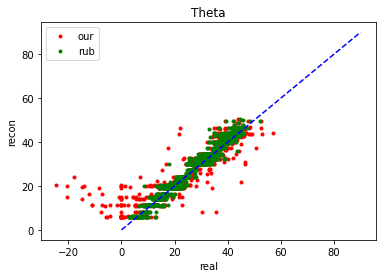

In [258]:
#without L
plt.plot(params_list[-1,:,1]*180/3.1415,theta[:,0]*180/3.1415,'r.',label='our')
plt.plot(recos[:,0],theta[:,0]*180/3.1415,'g.',label='rub')
plt.plot([0,90],[0,90],'b--')
plt.legend()
plt.xlabel('real')
plt.ylabel('recon')
plt.title('Theta')

Text(0.5, 1.0, 'Phi')

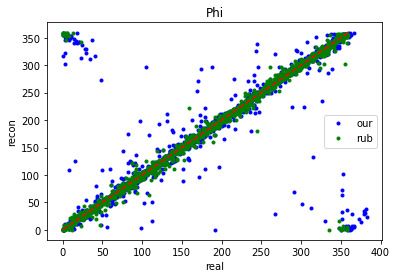

In [259]:
# withot chiL
plt.plot(tf.math.abs(params_list[-1,:,2]*180/3.1415),phi[:,0]*180/3.1415,'b.',label='our')
plt.plot(recos[:,1],phi[:,0]*180/3.1415,'g.',label='rub')
plt.plot([0,360],[0,360],'r--')
plt.legend()
plt.xlabel('real')
plt.ylabel('recon')
plt.title('Phi')

Text(0.5, 1.0, 'Phi')

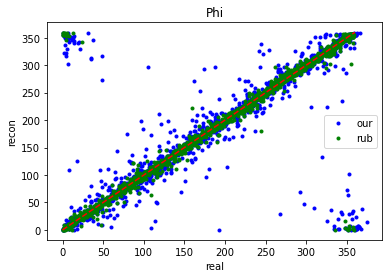

In [137]:
plt.plot(tf.math.abs(params_list[-1,:,2]*180/3.1415),phi[:,0]*180/3.1415,'b.',label='our')
plt.plot(recos[:,1],phi[:,0]*180/3.1415,'g.',label='rub')
plt.plot([0,360],[0,360],'r--')
plt.legend()
plt.xlabel('real')
plt.ylabel('recon')
plt.title('Phi')

Text(0.5, 1.0, 'theta')

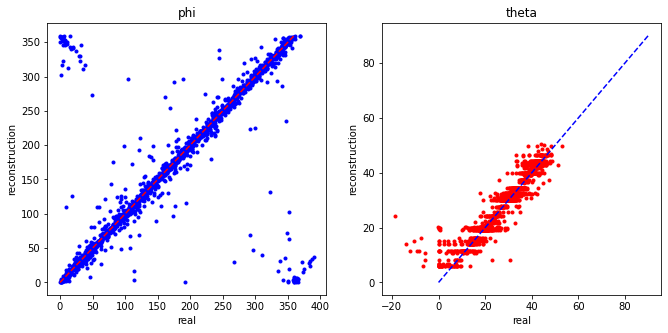

In [42]:
fig,axs = plt.subplots(1,2,figsize=(11,5))
axs[0].plot(tf.math.abs(params_list[-1,:,2]*180/3.1415),phi[:,0]*180/3.1415,'b.',label='our')
axs[0].plot([0,360],[0,360],'r--')
axs[1].plot(params_list[-1,:,1]*180/3.1415,theta[:,0]*180/3.1415,'r.',label='our')
axs[1].plot([0,90],[0,90],'b--')
axs[0].set_xlabel('real')
axs[0].set_ylabel('reconstruction')
axs[1].set_xlabel('real')
axs[1].set_ylabel('reconstruction')
axs[0].set_title('phi')
axs[1].set_title('theta')

Text(0.5, 1.0, 'without CHI_L')

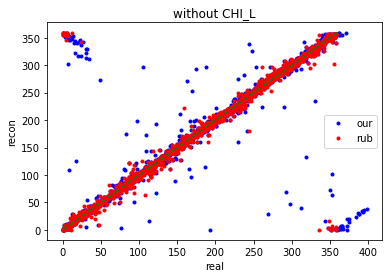

In [22]:
# withot chiL
plt.plot(tf.math.abs(params_list[-1,:,2]*180/3.1415),phi[:,0]*180/3.1415,'b.',label='our')
plt.plot(recos[:,1],phi[:,0]*180/3.1415,'r.',label='rub')
plt.plot([0,360],[0,360],'g--')
plt.legend()
plt.xlabel('real')
plt.ylabel('recon')
plt.title('without CHI_L')

Text(0, 0.5, 'рубцов')

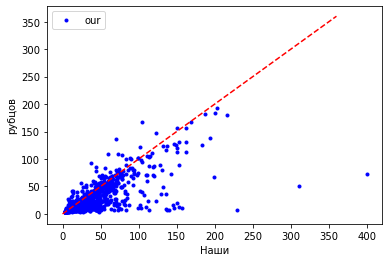

In [261]:
plt.plot(tf.math.abs(params_list[-1,:,4]),S800[:,0],'b.',label='our')
plt.plot([0,360],[0,360],'r--')
plt.legend()
plt.xlabel('Наши')
plt.ylabel('рубцов')
# plt.title('without CHI_L')

In [23]:
plt.plot(tf.math.abs(params_list[-1,:,4]),S800[:,0],'b.',label='our')
plt.plot([0,360],[0,360],'r--')
plt.legend()
plt.xlabel('Наши')
plt.ylabel('рубцов')
# plt.title('without CHI_L')

IndexError: index 4 is out of bounds for axis 2 with size 4

(2001, 2000, 5)


(array([931., 607., 210., 100.,  52.,  41.,  17.,   7.,  12.,   7.,   6.,
          2.,   2.,   2.,   3.,   1.,   0.,   0.,   0.,   0.]),
 array([  0. ,  12.5,  25. ,  37.5,  50. ,  62.5,  75. ,  87.5, 100. ,
        112.5, 125. , 137.5, 150. , 162.5, 175. , 187.5, 200. , 212.5,
        225. , 237.5, 250. ], dtype=float32),
 <a list of 20 Patch objects>)

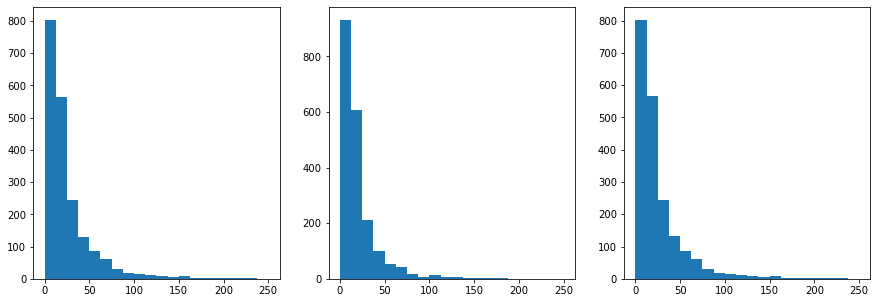

In [260]:
# S800
print(params_list.shape)
fig,axs=plt.subplots(1,3,figsize=(15,5))
axs[0].hist(params_list[0,:,4],bins=20, range=(0,250))
axs[2].hist(params_list[-1,:,4],bins=20, range=(0,250))
axs[1].hist(S800[:,0],bins=20, range=(0,250))

In [181]:
for i in tf.concat([params_list[-1,:,1:2]*180/3.1415,theta[:2000,0:1]*180/3.1415,recos[:2000,0:1],params_list__[-1,:,1:2]*180/3.1415],axis=1):
    print(i)

tf.Tensor([39.307613 40.799103 39.2557   50.74424 ], shape=(4,), dtype=float32)
tf.Tensor([35.96853  32.7505   36.0943   39.389507], shape=(4,), dtype=float32)
tf.Tensor([0.00053076 6.55946    7.64452    0.9607271 ], shape=(4,), dtype=float32)
tf.Tensor([ 0.02246671  6.55946     4.83893    -5.215947  ], shape=(4,), dtype=float32)
tf.Tensor([ 8.365888  6.55946   9.12421  23.287607], shape=(4,), dtype=float32)
tf.Tensor([ 4.30491    6.55946    4.09641   -2.1777403], shape=(4,), dtype=float32)
tf.Tensor([11.660404  6.55946   6.02779   6.499564], shape=(4,), dtype=float32)
tf.Tensor([5.118293  6.55946   5.67326   7.3830595], shape=(4,), dtype=float32)
tf.Tensor([ 0.00330372  6.55946     5.62831    -0.02344321], shape=(4,), dtype=float32)
tf.Tensor([ -3.4132795   6.55946     4.77911   -19.075195 ], shape=(4,), dtype=float32)
tf.Tensor([35.72807  32.3347   35.6531   42.685047], shape=(4,), dtype=float32)
tf.Tensor([29.201136 32.3347   30.5317   35.96953 ], shape=(4,), dtype=float32)
tf.Tenso

tf.Tensor([19.786839 20.3431   18.9747   13.992553], shape=(4,), dtype=float32)
tf.Tensor([21.495493 20.3431   21.4634   22.496325], shape=(4,), dtype=float32)
tf.Tensor([18.503006 20.3431   18.9002   18.604576], shape=(4,), dtype=float32)
tf.Tensor([20.655945 20.3431   21.8707   15.493991], shape=(4,), dtype=float32)
tf.Tensor([20.919632 20.3431   20.689    22.270947], shape=(4,), dtype=float32)
tf.Tensor([13.350384 20.3431   17.5712   14.569725], shape=(4,), dtype=float32)
tf.Tensor([19.904276 20.3431   18.698    27.19748 ], shape=(4,), dtype=float32)
tf.Tensor([19.350716 20.3431   19.1686   17.812948], shape=(4,), dtype=float32)
tf.Tensor([19.461525 20.3431   20.0695   16.478453], shape=(4,), dtype=float32)
tf.Tensor([20.641478 20.3431   19.3165    8.924065], shape=(4,), dtype=float32)
tf.Tensor([18.398228 20.3431   18.7918   17.346596], shape=(4,), dtype=float32)
tf.Tensor([19.66967  20.3431   20.0797   12.002918], shape=(4,), dtype=float32)
tf.Tensor([20.167746 20.3431   19.9439  

tf.Tensor([11.820308 11.438701 12.0742   10.825754], shape=(4,), dtype=float32)
tf.Tensor([44.717987 45.965    44.6461   46.6285  ], shape=(4,), dtype=float32)
tf.Tensor([42.02501  45.965    33.0534   33.741634], shape=(4,), dtype=float32)
tf.Tensor([44.56361 45.965   44.2031  36.14968], shape=(4,), dtype=float32)
tf.Tensor([45.42599  45.965    44.9482   47.954475], shape=(4,), dtype=float32)
tf.Tensor([45.643276 45.965    42.153    44.087563], shape=(4,), dtype=float32)
tf.Tensor([43.761833 45.965    43.8836   50.47101 ], shape=(4,), dtype=float32)
tf.Tensor([12.760277 13.99     13.8567   14.5727  ], shape=(4,), dtype=float32)
tf.Tensor([13.652211 13.99     14.1012   13.813412], shape=(4,), dtype=float32)
tf.Tensor([13.555072 13.99     13.7294   22.626686], shape=(4,), dtype=float32)
tf.Tensor([15.873264 13.99     12.8387   61.06549 ], shape=(4,), dtype=float32)
tf.Tensor([-0.00700793 13.99       13.4908     -0.0000567 ], shape=(4,), dtype=float32)
tf.Tensor([14.777234  13.99      14.

tf.Tensor([24.761072 24.209898 24.1178   33.19185 ], shape=(4,), dtype=float32)
tf.Tensor([23.403803  24.209898  22.8832     4.7240176], shape=(4,), dtype=float32)
tf.Tensor([27.120083 24.209898 27.3913   30.66784 ], shape=(4,), dtype=float32)
tf.Tensor([22.236908 24.209898 22.3012   17.068178], shape=(4,), dtype=float32)
tf.Tensor([23.7435   24.209898 23.1619   34.38397 ], shape=(4,), dtype=float32)
tf.Tensor([21.371521 24.209898 22.6187   50.254047], shape=(4,), dtype=float32)
tf.Tensor([23.337658 24.209898 23.2352   24.530083], shape=(4,), dtype=float32)
tf.Tensor([20.936012 24.209898 21.9749   21.843292], shape=(4,), dtype=float32)
tf.Tensor([24.022594 24.209898 23.8195    4.924162], shape=(4,), dtype=float32)
tf.Tensor([28.90026  24.209898 25.2228   22.381187], shape=(4,), dtype=float32)
tf.Tensor([24.845406 24.209898 24.6032   20.440022], shape=(4,), dtype=float32)
tf.Tensor([24.705341 24.209898 24.1199   29.131834], shape=(4,), dtype=float32)
tf.Tensor([20.895733 24.209898 21.27

tf.Tensor([39.87577  32.395397 38.962    45.914925], shape=(4,), dtype=float32)
tf.Tensor([28.610792  32.395397  34.6087     7.1288857], shape=(4,), dtype=float32)
tf.Tensor([38.895084 42.9446   40.2536   46.89607 ], shape=(4,), dtype=float32)
tf.Tensor([43.182144 42.9446   43.2882   47.4652  ], shape=(4,), dtype=float32)
tf.Tensor([40.653137 42.9446   40.139    46.02468 ], shape=(4,), dtype=float32)
tf.Tensor([38.584675 42.9446   36.385    61.892586], shape=(4,), dtype=float32)
tf.Tensor([46.02729  42.9446   44.5279   32.662727], shape=(4,), dtype=float32)
tf.Tensor([42.19795  42.9446   41.3365   44.122505], shape=(4,), dtype=float32)
tf.Tensor([42.28435  42.9446   42.1655   50.838024], shape=(4,), dtype=float32)
tf.Tensor([42.37589 42.9446  42.5582  70.7231 ], shape=(4,), dtype=float32)
tf.Tensor([41.461975 42.9446   41.6716   40.083706], shape=(4,), dtype=float32)
tf.Tensor([42.34048 42.9446  41.6765  42.87078], shape=(4,), dtype=float32)
tf.Tensor([41.866524 42.9446   42.1171   42.

Text(0, 0.5, 'recon')

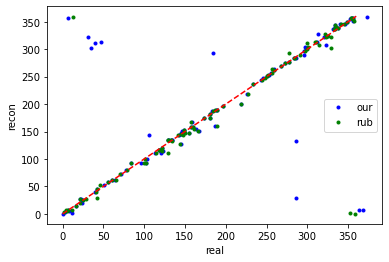

In [40]:
plt.plot(tf.abs(params_list[-1,:,2]*180/3.1415),phi[:100,0]*180/3.1415,'b.',label='our')
plt.plot(recos[:100,1],phi[:100,0]*180/3.1415,'g.',label='rub')
plt.plot([0,360],[0,360],'r--')
plt.legend()
plt.xlabel('real')
plt.ylabel('recon')

In [163]:
# phi 
params_list[-1,:,2]*180/3.1415

array([110.4019   , 185.75807  , 133.50099  , 308.4891   , 380.10236  ,
       216.00056  ,  31.922329 , -11.20899  , 255.7551   , 168.97673  ,
       324.18723  ,  68.490234 , 363.041    , 256.692    , 117.79535  ,
       170.11798  , 288.68396  , 226.74782  ,  11.428991 , 157.28307  ,
       147.83887  ,   0.5012963, 195.5255   , 162.30199  , 341.34412  ,
       149.6957   ,  47.187416 , 281.13858  , 319.6809   ,  95.038734 ,
       126.48585  , 249.18367  ,  23.84545  ,  48.373505 ,   2.3081775,
         6.8112407,   2.4732444, 339.5395   , 366.7993   , 150.68044  ,
       169.88058  ,  56.228306 , 154.15868  , 305.96716  , 142.58405  ,
        62.055786 ,  90.58363  ,  41.235355 ,  -3.1538308, 198.52365  ,
       148.76611  ,   2.0381722, 204.33992  , 262.57465  ,  27.682117 ,
       143.41429  ,  69.60372  , 255.84508  , 194.91487  , 188.95323  ,
       138.45636  , 297.42303  , 314.18585  ,  64.5595   , 173.42926  ,
       246.72592  , 343.33923  , 158.52773  , 343.3629   , 136.7

In [164]:
phi[:100,0]*180/3.1415

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([110.128     , 181.896     , 292.56104   , 132.034     ,
         6.33248   , 110.91699   , 310.731     , 301.68198   ,
        29.718699  , 159.512     , 323.625     , 117.254     ,
       355.848     , 283.80798   , 143.354     , 174.618     ,
       357.13803   , 218.87401   ,  20.1942    , 154.829     ,
       134.927     ,   3.5728102 , 186.847     , 150.76001   ,
       346.152     , 152.153     ,  39.814503  , 277.253     ,
       336.663     , 100.41599   , 114.934     , 261.905     ,
        24.6465    ,  27.35      , 142.953     , 357.52698   ,
       323.05402   , 344.218     , 358.59598   , 133.748     ,
       167.68599   ,  52.4621    , 150.617     , 264.82202   ,
       127.851     ,  92.0858    ,  92.87591   ,  27.479     ,
       312.60098   , 200.86198   , 147.069     ,   1.52536   ,
       326.88797   , 350.592     ,   5.3751903 , 134.526     ,
        91.8993    , 255.911     , 188.47      , 196.22899   ,
       

# Обучение Нейронки

In [49]:
noise_dim=50
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.9)

In [50]:
detectors_rub[1,:,:,1]

array([[-6.        , -6.        , -6.        , -6.        , -6.        ,
        -6.        ],
       [-6.        , -6.        , -0.542352  ,  0.6625092 , -6.        ,
        -6.        ],
       [-6.        , -6.        , -0.5548644 ,  0.6544056 , -6.        ,
        -6.        ],
       [-6.        , -6.        , -0.5483316 ,  0.6509472 , -6.        ,
        -6.        ],
       [-6.        , -6.        , -6.        ,  0.59666646, -6.        ,
        -6.        ],
       [-6.        , -6.        , -6.        , -6.        , -6.        ,
        -6.        ]], dtype=float32)

In [51]:
class Det2Core(tf.keras.layers.Layer):
#     @tf.function(input_signature=[tf.TensorSpec([None,3])])
    def call(self,det_core,dist=1.2):
        x= tf.cast(tf.repeat(tf.expand_dims(tf.range(5,-1,-1),1),6,axis=1),tf.float32)
        y = tf.cast(tf.repeat(tf.expand_dims(tf.range(5,-1,-1),0),6,axis=0),tf.float32)
        x = tf.expand_dims(x,-1)
        y = tf.expand_dims(y,-1)
        z =tf.zeros_like(x)
        detectors = tf.concat([x,y,z],axis=-1) * dist
#         print(detectors)
#         detectors = tf.repeat(tf.expand_dims(detectors,0),batch,0)
        res = tf.where (det_core == np.array([-6,-6,0]),np.nan, detectors + det_core) 
        print(res[1,:,:,0])
        core = tf.convert_to_tensor(tf.experimental.numpy.nanmean(res,axis=(1,2)))
#         return tf.TensorSpec.from_tensor(core)
        return core
det2core = Det2Core()
det2core(detectors_rub[:2])

tf.Tensor(
[[      nan       nan       nan       nan       nan       nan]
 [      nan       nan 3.1437602 3.126276        nan       nan]
 [      nan       nan 3.1311278 3.1411057       nan       nan]
 [      nan       nan 3.136656  3.1377985       nan       nan]
 [      nan       nan       nan 3.047244        nan       nan]
 [      nan       nan       nan       nan       nan       nan]], shape=(6, 6), dtype=float32)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.1796193 , 2.780812  , 0.03348011],
       [3.123424  , 3.0455685 , 0.04572365]], dtype=float32)>

In [14]:
# ep=199
# generator=tf.keras.models.load_model('../Models/deep_5/save_model/generator/ep'+str(100))
discriminator=tf.keras.models.load_model('../Models/deep_5/save_model/discriminator/ep'+str(100))
# noise = tf.random.normal(shape=(100,50))
# fake_data=generator(noise)#change
# print(tf.math.reduce_mean(discriminator(fake_data)))

# print(tf.math.reduce_mean(discriminator(data[-100:])))

In [15]:
def Conditional_generator(generator,num="",noise_dim=50):
    input_noise=tf.keras.Input(shape=(noise_dim,))
    input_detectors = tf.keras.Input(shape=(6,6,3)) # don't use like input generator
    input_core = det2core(input_detectors)
    input_theta = tf.keras.Input(shape=(1,))
    input_phi = tf.keras.Input(shape=(1,))
    input_courve =tf.keras.Input(shape=(1,))
    input_S800 =  tf.keras.Input(shape=(1,))
    
    input_tensor = tf.keras.layers.concatenate([input_noise,input_core,input_theta,input_phi,input_courve,input_S800])
    noise = tf.keras.layers.Dense(noise_dim)(input_tensor)
    result = generator(noise)
    model= tf.keras.Model([input_noise,input_detectors,input_theta,input_phi,input_courve,input_S800],
                          result,
                          name="Generator_model_{}".format(num))
    return model
cond_generator = Conditional_generator(tf.keras.models.load_model('../Models/deep_5/save_model/generator/ep'+str(100)))
cond_generator.summary()

Model: "Generator_model_"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6, 6, 3)]    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
det2_core (Det2Core)            (None, 3)            0           input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
___________________________________________________________________________________

# TRAIN

In [16]:
# cd Parameters_all/

In [52]:
max_c=tf.reshape(tf.constant([i[0] for i in norm_params.values()]),(1,1,1,4))
min_c=tf.reshape(tf.constant([i[1] for i in norm_params.values()]),(1,1,1,4))
max_c,min_c

(<tf.Tensor: shape=(1, 1, 1, 4), dtype=float32, numpy=array([[[[445.172,  11.   ,  11.974,   1.   ]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 1, 4), dtype=float32, numpy=array([[[[  0.   , -10.487,  -2.573,   0.   ]]]], dtype=float32)>)

In [53]:
def renorming(data,max_c = max_c,min_c = min_c,log=True):
    data = data*(max_c-min_c) + min_c
#     if (i==0 and log):
#         data = data[:,:,:,i].assign(tf.math.exp(data[:,:,:,i])-1)
#     #         elif (i==1 or i==2):
#     #             data[:,:,:,i]=data[:,:,:,i]#*1e6
    return data

In [54]:
def im_one(i,data,axs):
    signal=data[i,:,:,0]
    real_time=data[i,:,:,1]+data[i,:,:,2]
    mask=data[i,:,:,3]
    sns.heatmap(data[i,:,:,0]*mask,annot=data[i,:,:,0]*mask,ax=axs[i,0],vmin=0.0, vmax=1.0)
    sns.heatmap(real_time*mask,annot=real_time*mask,ax=axs[i,1],vmin=-1.0, vmax=1.0)

def image_signal(data,fake=None,dir_name=None,ep='not_ep'):
    n=data.shape[0]
    if (fake is None):
        fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(10,n*5))
#         Parallel(n_jobs=-1)(delayed(im_one)(i,data,axs) for i in range(n))
        for i in range(n):
            im_one(i,data,axs)
            axs[i,0].set_title(f'number {str(i)}')
                           
        fig.suptitle('only real')
    else:
        fig, axs = plt.subplots(nrows=n, ncols=4, figsize=(10*2,n*5))
        data_after = renorming(data)
        data_after = tf.where(tf.cast(tf.expand_dims(data_after[:,:,:,-1],axis=-1),tf.bool),data_after[:,:,:,:],np.nan)
        fake_after = renorming(fake)
        fake_mask = tf.cast(tf.where(tf.cast(fake_after[:,:,:,3:4]>0.5,tf.bool),1,0),tf.float32)
        fake_after *= fake_mask
        fake_after = tf.where(tf.cast(tf.expand_dims(fake_after[:,:,:,-1],axis=-1),tf.bool),fake_after[:,:,:,:],np.nan)
        for i in range(n):
            sns.heatmap(data_after[i,:,:,0],annot=data_after[i,:,:,0],ax=axs[i,2],fmt=".1f")
            sns.heatmap(data_after[i,:,:,1],annot=data_after[i,:,:,2],ax=axs[i,3],fmt=".2f")
            
            
            sns.heatmap(fake_after[i,:,:,0],annot=fake_after[i,:,:,0],ax=axs[i,0],fmt=".1f")
            sns.heatmap(fake_after[i,:,:,1],annot=fake_after[i,:,:,2],ax=axs[i,1],fmt=".2f")
        fig.suptitle('fake     /    real')
    if dir_name:
        plt.savefig("{}/save_images/epoch{}.png".format(dir_name,ep))
        plt.close()
        
def images(cond_generator,num, data_all,
           noise_dim=noise_dim, dir_name='', ep='not_ep'):
    shape = (6,6,4)
    rand=np.random.choice(np.arange(len(data_all)),num)
    data_for_plot=np.zeros((num,shape[0],shape[1],shape[2]))
    det_l = np.zeros((num,6,6,3))
    theta_l = np.zeros((num,1))
    phi_l = np.zeros((num,1))
    courve_l = np.zeros((num,1))
    S800_l = np.zeros((num,1))
    for i in range(num):
        data, det, theta, phi, courve, S800 = data_all[rand[i]]
#         print(data.shape, det, theta, phi, courve, S800)
        data_for_plot[i]=data
        det_l[i] = det
        theta_l[i] = theta
        phi_l[i] = phi
        courve_l[i] = courve
        S800_l[i] = S800
    noise = tf.random.normal(shape=(num,noise_dim))
    fake=cond_generator([noise,det_l, theta_l, phi_l, courve_l,S800_l])
    fake = np.array(fake)
    image_signal(data_for_plot,fake=fake,dir_name=dir_name,ep=ep)

In [55]:
# images(cond_generator,2, test)

In [56]:
def discriminator_loss(real_output, fake_output):
    real_loss = -tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def reco_loss(real_time, detectors,t0,theta,phi,courve,mask,S800):
    return reco.chiT_by_param(real_time, detectors,t0,theta,phi,courve,mask,S800)
def loss_time(data,kof=10,res=tf.Variable(0,dtype=tf.float32)):
#     res=tf.Variable(0,dtype=tf.float32)
    for i in range(data.shape[0]):
        data_n=tf.where(tf.cast(tf.expand_dims(data[i,:,:,3],axis=-1),tf.bool),data[i],np.nan)
        arg=tf.where(data_n[:,:,0] == tf.math.reduce_max(data[i,:,:,0]))[0]
        time=data_n[arg[0],arg[1],2]
        min_time=tf.math.reduce_min(tf.where(tf.math.is_nan(data_n[:,:,2]),np.inf,data_n[:,:,2]))
        res=res+time-min_time
    return(res/data.shape[0]*kof)
        
#     max_active_time=
def generator_loss(fake_output):
#     return loss_function(tf.ones_like(fake_output), fake_output)
    return -tf.reduce_mean(fake_output)

def gradient_penalti(batch,real_data,fake_data):
#   alpha = tf.random.normal([batch, 1], 0.0, 1.0)
#   diff = fake_data - real_data
#   interpolated = real_data + alpha * diff
    epsilon=tf.random.uniform(shape=(batch,1,1,1),dtype=tf.dtypes.float32)
#     print(epsilon)
    interpolated=real_data-epsilon*(real_data-fake_data)# вычисление x^ как в статье
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred=discriminator(interpolated,training=True)  # D(x^)
    grads = gp_tape.gradient(pred, [interpolated])[0]# because list
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp    
@tf.function
def train_step_WGAN(labda,batch,real_data,weight_gp,weight_corr):
  # labda --> number learling critic
  #weight --> weight gradient_penalti

  #learning critic
    real_time = real_data[:,:,:,1:2] +real_data[:,:,:,2:3]
    mask = real_data[:,:,:,3:4]
    t0=tf.constant(0, dtype=tf.float32)
    for i in range(labda):
        with tf.GradientTape() as gr:
            noise = tf.random.normal(shape=(batch,noise_dim))
            fake_data=generator(noise)#change
#             print('f')
            real_data=real_data
            fake_predict=discriminator(fake_data)
            real_predict=discriminator(real_data)
            real_data=tf.cast(real_data,dtype=tf.float32)
            gp=gradient_penalti(batch,real_data,fake_data)
            disc_loss=discriminator_loss(real_predict,fake_predict)+weight_gp*gp # critic loss include GP
        d_grad=gr.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(d_grad, discriminator.trainable_variables))
  #learning generator
    noise = tf.random.normal(shape=(batch,noise_dim))
    with tf.GradientTape() as gr:
        fake_data=generator(noise)
        fake_predict=discriminator(fake_data)
        gen_loss=generator_loss(fake_predict)
        gen_loss=gen_loss+ loss_time(fake_data) #+ reco_loss(fake_time, detectors,t0,theta,phi,courve,mask)
    g_grad=gr.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(g_grad, generator.trainable_variables))
    return (gen_loss,disc_loss,loss_time(fake_data))
@tf.function
def train_step_COND_WGAN(real_data, detectors, t0, theta, phi, courve, S800,
                         batch,labda=5,weight_gp=10):
  # labda --> number learling critic
  #weight --> weight gradient_penalti

  #learning critic
    real_time = real_data[:,:,:,1:2] +real_data[:,:,:,2:3]
    mask = real_data[:,:,:,3:4]
    t0=tf.constant(0, dtype=tf.float32)
    for i in tf.range(labda):
        with tf.GradientTape() as gr:
            noise = tf.random.normal(shape=(batch,noise_dim))
            fake_data=cond_generator([noise,detectors, theta, phi, courve,S800])#change
#             print('f')
            real_data=real_data
            fake_predict=discriminator(fake_data)
            real_predict=discriminator(real_data)
            real_data=tf.cast(real_data,dtype=tf.float32)
            gp=gradient_penalti(batch,real_data,fake_data)
            disc_loss=discriminator_loss(real_predict,fake_predict)+weight_gp*gp # critic loss include GP
        d_grad=gr.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(d_grad, discriminator.trainable_variables))
  #learning generator
    noise = tf.random.normal(shape=(batch,noise_dim))
    with tf.GradientTape() as gr:
        fake_data=cond_generator([noise,detectors, theta, phi, courve,S800])
        fake_predict=discriminator(fake_data)
        
        gen_loss=generator_loss(fake_predict)
        gen_loss=gen_loss+ loss_time(fake_data)
        
        fake_data_renorm = renorming(fake_data,log=False)
        fake_time= fake_data_renorm[:,:,:,1:2] +fake_data_renorm[:,:,:,2:3]
        #renorming
        theta = renorm_params(theta,theta_t,theta_b)
        phi = renorm_params(phi,phi_t,phi_b)
        courve = renorm_params(courve,courve_t,courve_b)
        S800 = renorm_params(S800,S800_t,S800_b)
        
        gen_loss=gen_loss+ reco_loss(fake_time, detectors*6,t0,theta,phi,courve,mask,S800)
    g_grad=gr.gradient(gen_loss,cond_generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(g_grad, cond_generator.trainable_variables))
    return (gen_loss,disc_loss)
def func_chunks_generators(lst, n):
    '''передается масив и число.масив разбивается на масивы длиной не более n
    пример func_chunks_generators([1,2,3,4,5], 3) -> [[1,2,3],[4,5]]
    lst- масив
    n- число, пределяющее максимальную длину'''
    l=[]
    for i in range(0, len(lst), n):
         l.append(lst[i : i + n])
    return(l)

In [57]:
batch=2
epochs=250
ep_start=0
g_list=[]
d_list=[]
time_list=[]
def train_WGAN(epochs,train_data,test_data,batch,dir_name):
    lamda = tf.constant(5,dtype=tf.float32)
    weight_gp = tf.constant(10,dtype=tf.float32)
    if not(os.path.exists(dir_name)):
        os.mkdir(dir_name)
        os.mkdir(os.path.join(dir_name,'save_images'))
        os.mkdir(os.path.join(dir_name,'save_model'))
        os.mkdir(os.path.join(dir_name,'save_model/discriminator'))
        os.mkdir(os.path.join(dir_name,'save_model/generator'))
#     data, detectors_rub, theta, phi, courve, S800 = train_data
    data = [i[0] for i in train_data]
    detectors_rub = [i[1] for i in train_data]
    theta = [i[2] for i in train_data]
    phi = [i[3] for i in train_data]
    courve = [i[4] for i in train_data]
    S800 = [i[5] for i in train_data]
    train_data = func_chunks_generators(data, batch)
    detectors_rub = func_chunks_generators(detectors_rub, batch)
    t0=tf.constant(0,dtype=tf.float32)
    theta = func_chunks_generators(theta, batch)
    phi = func_chunks_generators(phi, batch)
    courve = func_chunks_generators(courve, batch)
    S800 = func_chunks_generators(S800, batch)
    for j in tqdm_notebook(range(ep_start,epochs),'ep'):
        for num in tqdm_notebook(range(0,len(train_data)),f'epoch num{j}'):
            step_data=tf.Variable(train_data[num],dtype = tf.float32)
            step_theta =tf.Variable(theta[num],dtype = tf.float32)
            step_phi = tf.Variable(phi[num],dtype = tf.float32)
            step_courve = tf.Variable(courve[num],dtype = tf.float32)
            step_detectors_rub = tf.Variable(detectors_rub[num],dtype = tf.float32)
            step_S800 = tf.Variable(S800[num],dtype = tf.float32)
            all_data = (step_data,step_detectors_rub,t0,step_theta,step_phi,step_courve, step_S800)
#             train_step_WGAN(labda=5,batch=2,real_data=step_data,weight_gp=10,weight_corr=1)
            g,d=train_step_COND_WGAN(step_data,step_detectors_rub,t0,step_theta,step_phi,step_courve, step_S800,
                                     batch = tf.constant(step_data.shape[0]),labda=lamda,weight_gp=weight_gp)
            d_list.append(d)
            g_list.append(g)
#             time_list.append(t)
        if (j % 10 == 0):
            images(cond_generator,num=10, data_all=test,
                   noise_dim=noise_dim,dir_name=dir_name,ep=j)
            discriminator.save("{}/save_model/discriminator/ep{}".format(dir_name,j))
            cond_generator.save("{}/save_model/generator/ep{}".format(dir_name,j))
            plt.close()
dir_name = '../Models/Conditional+Phys_loss'
train_WGAN(epochs,train,test,batch,dir_name=dir_name)

plt.close()
plt.figure()
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.plot(time_list[5000::100],'b')
plt.legend(['disc','gen'])
# plt.ylim(-5,5)
plt.title(dir_name)
plt.savefig(os.path.join(dir_name,'loss.jpg'))
df=pd.DataFrame({'disc':d_list,'gen':g_list,"time":time_list})
df.to_csv("{}/loss.csv".format(dir_name))

KeyboardInterrupt: 

In [ ]:
type(train)

NameError: name 'dir_name' is not defined

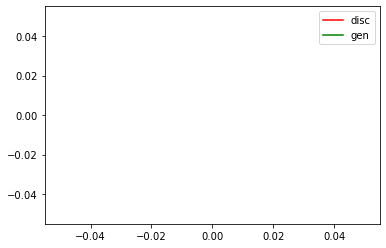

In [92]:
plt.figure()
plt.plot(d_list,'r')
plt.plot(g_list,'g')
# plt.plot(time_list[5000::100],'b')
plt.legend(['disc','gen','time'])
# plt.ylim(-5,5)
plt.title(dir_name)
# plt.savefig(os.path.join(dir_name,'loss.jpg'))

In [41]:
df=pd.DataFrame({'disc':d_list,'gen':g_list,"time":time_list})
df.to_csv("{}/loss.csv".format(dir_name))

Text(0.5, 1.0, 'deep_5_+loss')

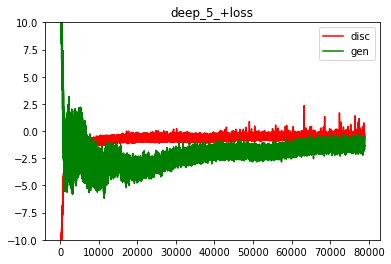

In [45]:
plt.plot(d_list,'r')
plt.plot(g_list,'g')
plt.legend(['disc','gen'])
plt.ylim(-10,10)
plt.title(dir_name)
# plt.savefig(os.path.join('deep_7_2','loss.jpg'))

Text(0.5, 1.0, 'deep_res')

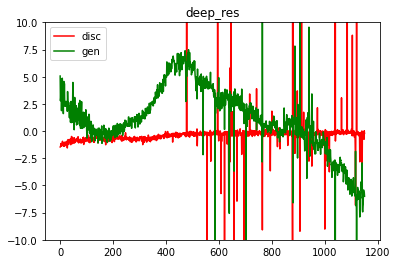

In [45]:
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.legend(['disc','gen'])
plt.ylim(-10,10)
plt.title(dir_name)
# plt.savefig(os.path.join('deep_7_2','loss.jpg'))

Text(0.5, 1.0, 'deep_7')

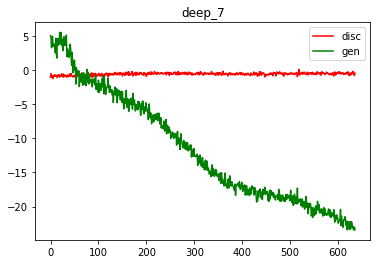

In [25]:
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.legend(['disc','gen'])
# plt.ylim(-5,5)
plt.title(dir_name)

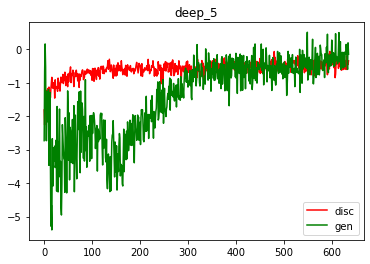

In [27]:
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.legend(['disc','gen'])
# plt.ylim(-5,5)
plt.title(dir_name)
plt.savefig(os.path.join(dir_name,'loss.jpg'))

  0%|          | 8/3000 [00:00<01:36, 30.86it/s]


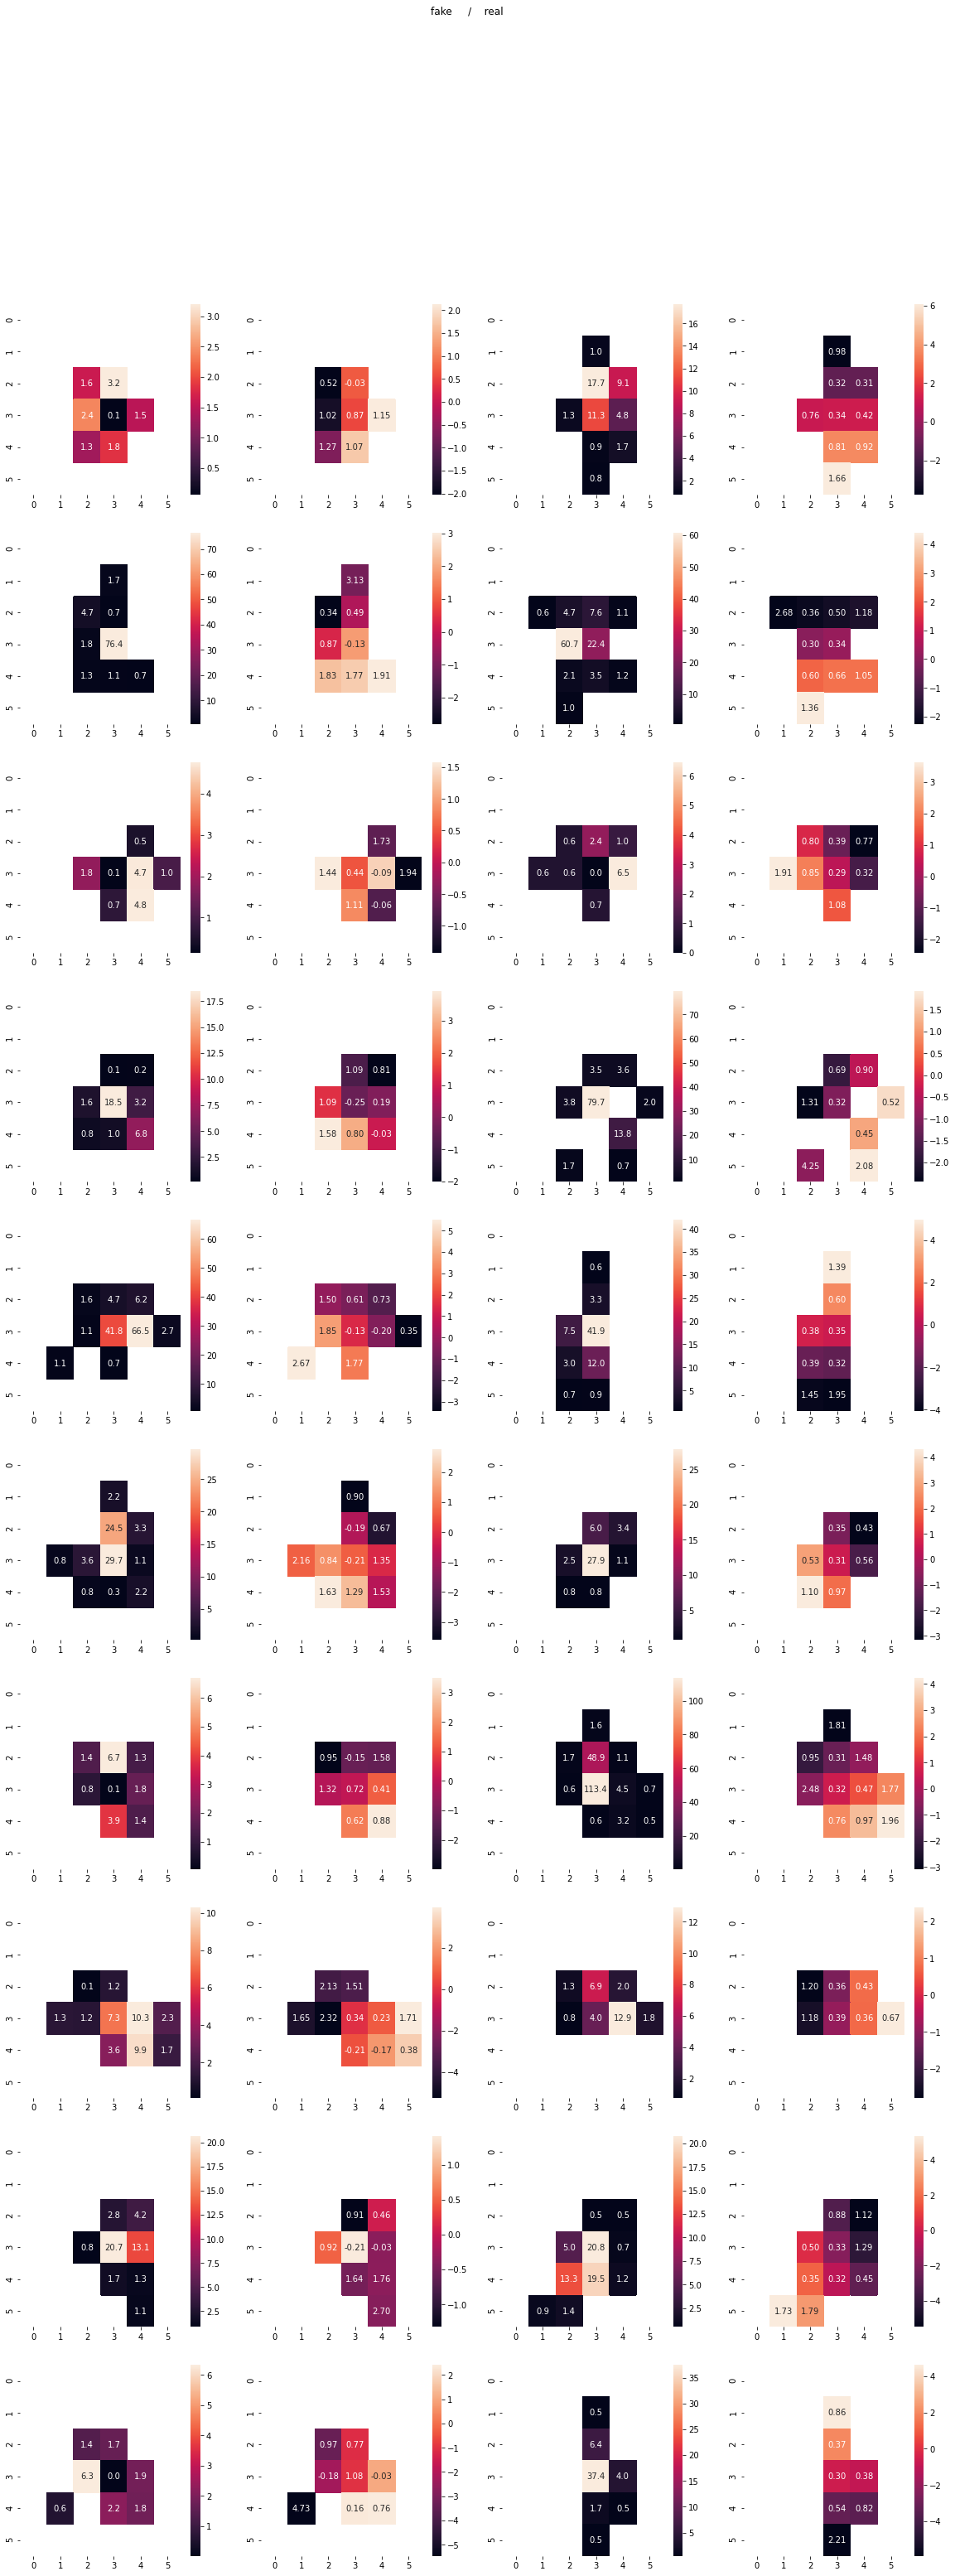

In [30]:
ep=199
generator=tf.keras.models.load_model('deep_5/save_model/generator/ep'+str(ep))
discriminator=tf.keras.models.load_model('deep_5/save_model/discriminator/ep'+str(ep))
def Residual_loss(data_true, data_fake):
    return tf.reduce_mean( tf.math.abs(data_true - data_fake),axis=(1,2,3))# сделать универсально
def Discriminator_loss(data_true, data_fake,discriminator):
    real_pred=discriminator(data_true)
    fake_pred=discriminator(data_fake)
    return tf.math.abs( real_pred - fake_pred)
loss_L=[]
def find_noise(generator,discriminator,image,noise_dim,alpha=1.2,k_rd=0.0001):
#         global loss_L
#     print(image.sha)
    global loss_L
    loss_befor=1000000000
    k=0
    noise = tf.random.normal(shape=(image.shape[0],noise_dim))
    noise_befor=tf.identity(noise)
    for i in tqdm.tqdm(range(3000)):
        with tf.GradientTape() as tape:
            tape.watch(noise)
            fake=generator(noise)
            loss=Residual_loss(image, fake)
            loss_disc=Discriminator_loss(image, fake,discriminator)*k_rd
            Loss=tf.reshape(loss,(-1,1))+loss_disc
            loss_L.append(Loss)
        g_grad=tape.gradient(Loss,noise)
        noise=noise-alpha*g_grad
        if tf.math.reduce_mean((loss_befor-Loss))<0.005*tf.math.reduce_mean(Loss):
            k+=1
            if k>7:
                break
        else:
            loss_befor=Loss
            k=0
            
    return (noise,noise_befor)
def images_define(generator,num=10,data=data,noise_dim=noise_dim,dir_name='',ep='not_ep'):
    rand=np.random.choice(np.arange(data.shape[0]),num)
    data_for_plot=np.zeros((num,shape[0],shape[1],shape[2]))
    fake=np.zeros((num,shape[0],shape[1],shape[2]))
    for i in range(num):
        data_for_plot[i]=data[rand[i]]
        noise = find_noise(generator,discriminator,np.array([data_for_plot[i]]),noise_dim,alpha=1.2,k_rd=0.0001)[0]
        fake[i]=generator(noise)
    image_signal(data_for_plot,fake=fake,dir_name=dir_name,ep=ep)

images_define(generator,num=10,data=data,noise_dim=noise_dim,dir_name='',ep='not_ep')
